In [80]:
import os
import sklearn.cluster
import sklearn.datasets
import sklearn.metrics
import sklearn.metrics.cluster
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import time
import seaborn as sns
from pathlib import Path
import csv
%matplotlib inline
sns.set_context('poster')
sns.set_palette('Paired', 10)
sns.set_color_codes()

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

   os.environ['OMP_NUM_THREADS'] = '1'

In [81]:
script_dir = os.getcwd()
data_dir = os.path.join(script_dir, '..', 'data')
result_graph = os.path.join(script_dir, '..', 'result', 'graph')
result_dados = os.path.join(script_dir, '..', 'result', 'dados.csv')

result_dados = Path(result_dados)
if result_dados.is_file():
    os.remove(result_dados);

def load_file(filename, className):
  file_path = os.path.join(data_dir, filename)

  try:
    data = pd.read_csv(file_path)
    dataOnly = data.drop(className, axis='columns')
    labelsOnly = data[className]

    encoder = LabelEncoder()

    dict = {'Filename': filename,
        'DataOnly': dataOnly,
        'Data': data,
        'LabelsOnly': encoder.fit_transform(labelsOnly),
        'LabelsEncoded': encoder.classes_,
        'LabelsOnlyEncoded': labelsOnly
        }

    return dict
  except FileNotFoundError:
    print(f"Arquivo {filename} não encontrado no diretório {data_dir}")
    return None
  except pd.errors.EmptyDataError:
    print(f"Arquivo {filename} está vazio")
    return None
  except pd.errors.ParserError:
    print(f"Erro ao analisar o arquivo {filename}")
    return None

def plot_confusion_matrix(
                          executionId,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          printNumberFormatGraph = '0.4f',
                          printNumberFormatLegend = None):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, ("{:"+printNumberFormatGraph+"}").format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    if(printNumberFormatLegend == None):
      printNumberFormatLegend = printNumberFormatGraph

    plt.tight_layout()
    plt.ylabel('Nomes verdadeiros')
    plt.xlabel(('Nomes preditos\nAcurácia={:'+printNumberFormatLegend+'}').format(accuracy))

    result_graph_file = os.path.join(result_graph, ('{:}.png').format(executionId))
    result_graph_file = Path(result_graph_file)
    if result_graph_file.is_file():
        os.remove(result_graph_file);

    plt.savefig(result_graph_file, dpi=300, transparent=True);
    #plt.show()
    #return plt;

In [82]:
data= load_file("iris.csv", "class")
print(data["Filename"])
#print(data["DataOnly"].head())
#print(data["Data"].head())
#print(data["LabelsOnly"].head())
print(data["LabelsEncoded"])


iris.csv
['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [83]:
def benchmark_algorithm(executionId, datasetName, dataset, cluster_function_name, cluster_function, function_args, function_kwds, sample_size=2):
    start_time = time.time()
    cluster = cluster_function(dataset["DataOnly"], *function_args, **function_kwds)
    time_taken = time.time() - start_time

    labels_ = []

    if(type(cluster).__module__ != np.__name__):
        labels_ = cluster.labels_;
    #else:
    #    labels_ = cluster;

    encoder = LabelEncoder()
    encoder.fit_transform(labels_),
    clusterClasses = encoder.classes_

    contingency = sklearn.metrics.cluster.contingency_matrix(dataset["LabelsOnly"], labels_)

    clusterLabels = labels_.astype("object");

    for idx2, newClusterLabel in enumerate(clusterClasses):
        maxValue = -1;
        maxLabel = "";
        for idx, p in enumerate(dataset['LabelsEncoded']):
            if(contingency[idx][idx2] > maxValue):
                maxValue = contingency[idx][idx2];
                maxLabel = dataset['LabelsEncoded'][idx];
        
        clusterLabels[clusterLabels==newClusterLabel] = maxLabel

    confusion_matrix = sklearn.metrics._classification.confusion_matrix(dataset["LabelsOnlyEncoded"], clusterLabels, normalize='all')
    cmd = plot_confusion_matrix(executionId=executionId,
                                cm=confusion_matrix,
                                target_names=dataset["LabelsEncoded"],
                                title=(datasetName+' - '+cluster_function_name + ' (Id: {:})').format(executionId),
                                printNumberFormatGraph=".0%",
                                printNumberFormatLegend=".1%")
    
    purity_score = np.sum(np.amax(confusion_matrix, axis=0)) / np.sum(confusion_matrix)
    jaccard_score = sklearn.metrics._classification.jaccard_score(dataset["LabelsOnlyEncoded"], clusterLabels, average='micro')
    adjusted_rand_score = sklearn.metrics.cluster.adjusted_rand_score(dataset["LabelsOnlyEncoded"], clusterLabels)
    accuracy_score = sklearn.metrics._classification.accuracy_score(dataset["LabelsOnlyEncoded"], clusterLabels)

    #classification_report = sklearn.metrics.classification_report(dataset["LabelsOnlyEncoded"], clusterLabels, target_names=dataset["LabelsEncoded"], zero_division=0)

    result = {'ClusterFunctionName': cluster_function_name,
        'Cluster': cluster,
        'TimeTaken': time_taken,
        'ClusterLabels': clusterLabels,
        'AccuracyScore': accuracy_score,
        'PurityScore': purity_score,
        'AdjustedRandScore': adjusted_rand_score,
        'JaccardScore': jaccard_score,
        #'ContingencyMatrix': contingency,
        'ConfusionMatrix': confusion_matrix,
        #'ClassificationReport': classification_report,
        #'ConfusionMatrixDisplay': cmd
        }

    return result

Iris Dataset



c:\Users\Alan Melo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_birch.py:725: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (4). Decrease the threshold.
  warnings.warn(
c:\Users\Alan Melo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (6). Decrease the threshold.
  warnings.warn(
C:\Users\Alan Melo\AppData\Local\Temp\ipykernel_20644\4184032266.py:89: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 10))
c:\Users\Alan Melo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_birch.py:725: ConvergenceWarning: N

Rice Dataset



c:\Users\Alan Melo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (3). Decrease the threshold.
  warnings.warn(
c:\Users\Alan Melo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (4). Decrease the threshold.
  warnings.warn(
c:\Users\Alan Melo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (6). Decrease the threshold.
  warnings.warn(


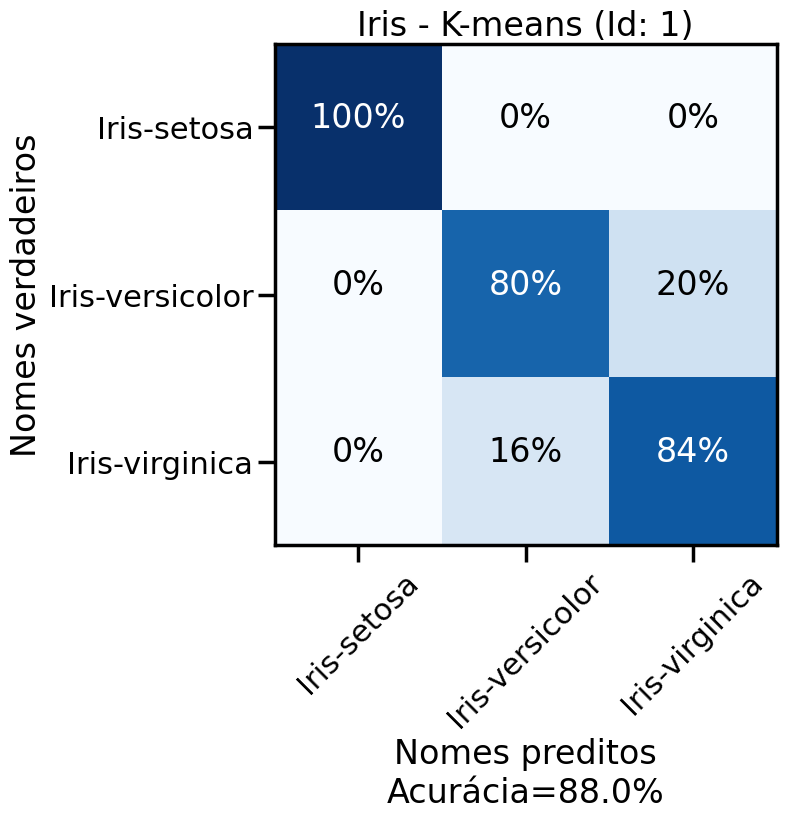

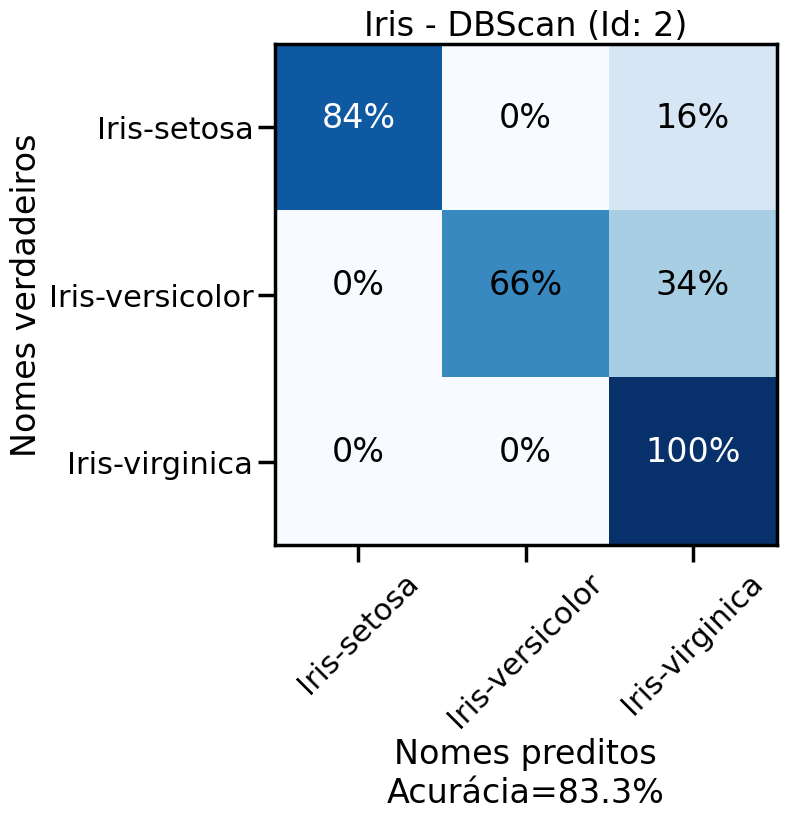

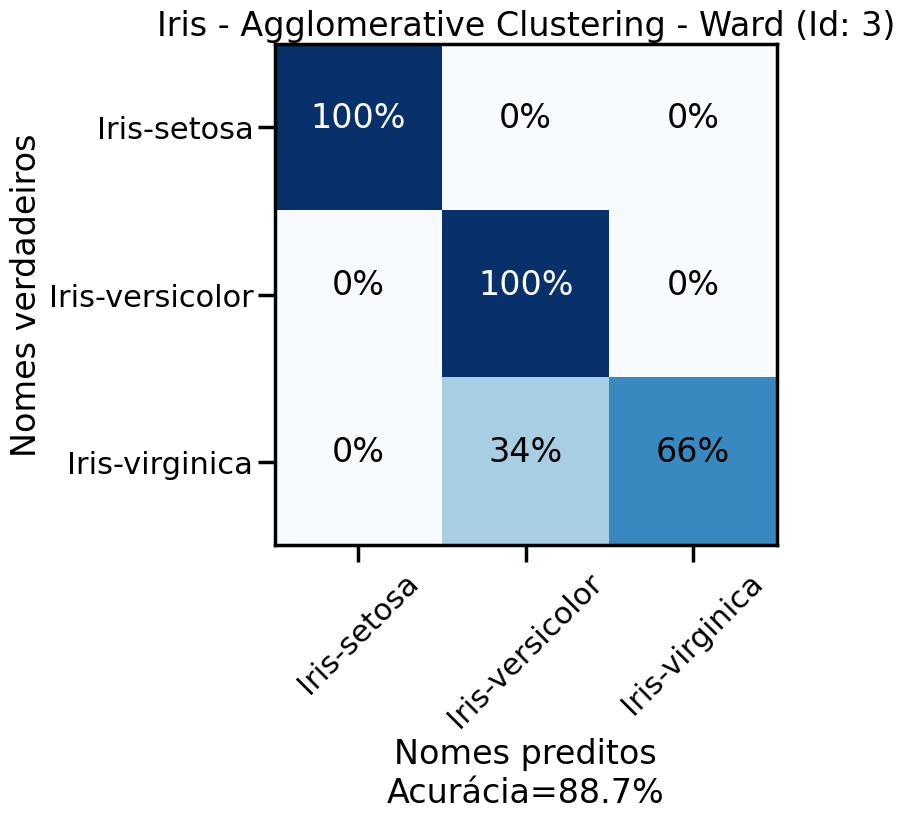

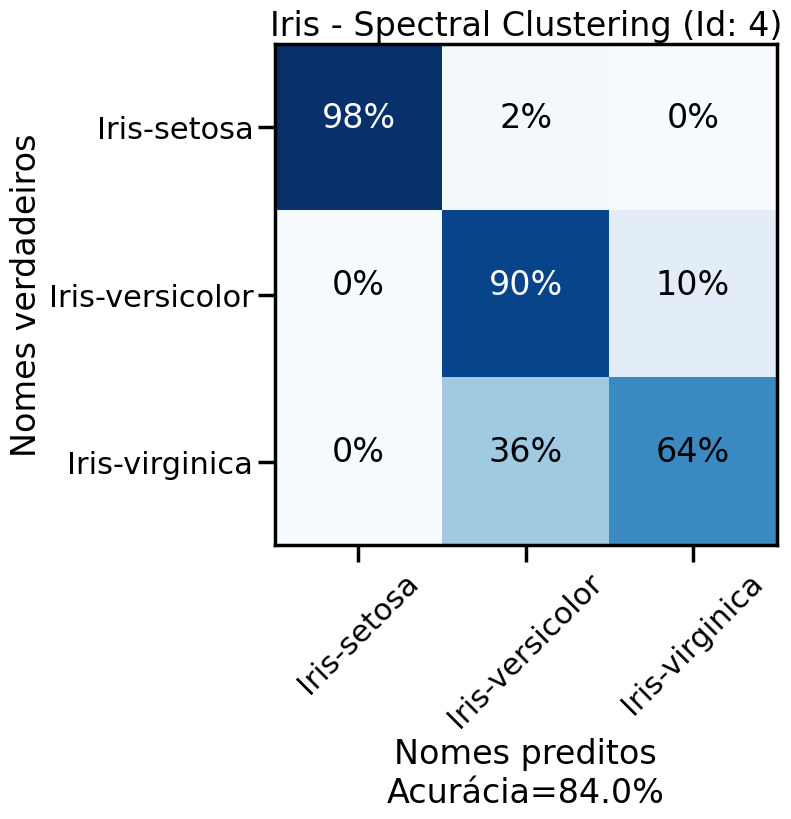

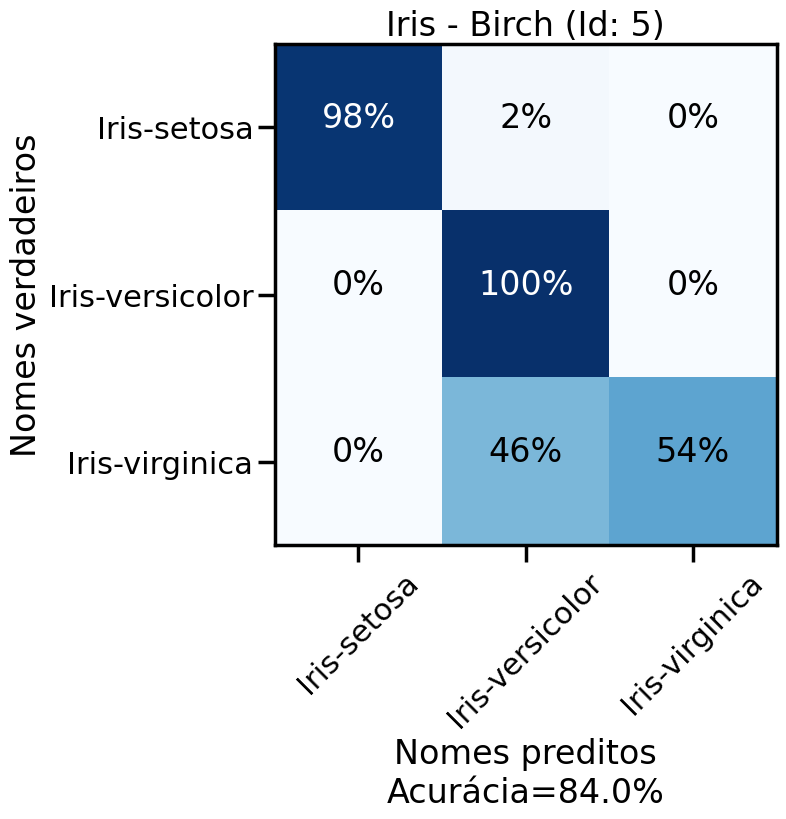

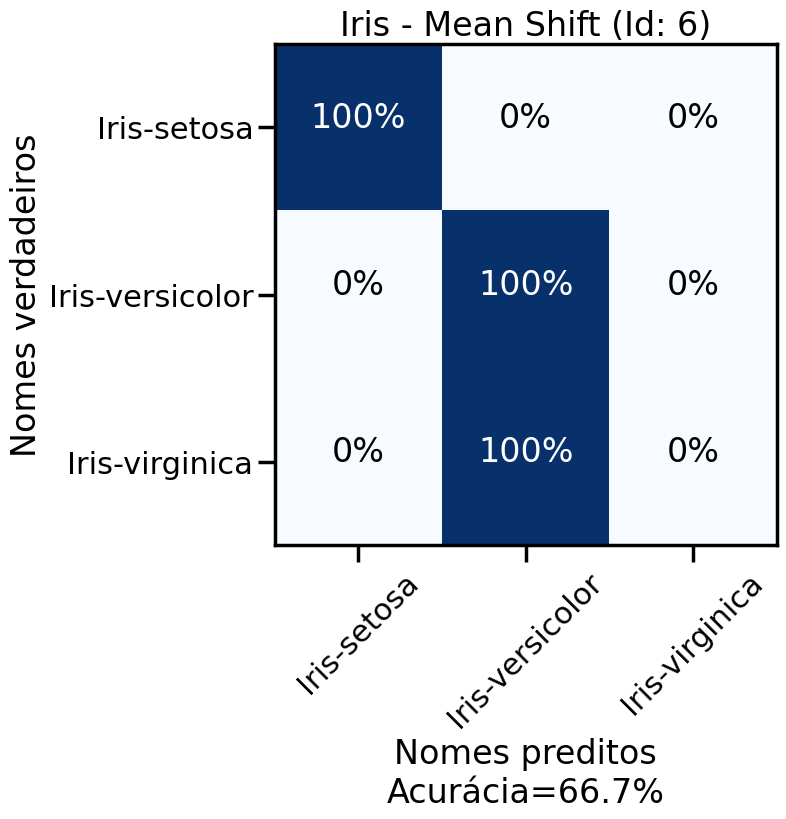

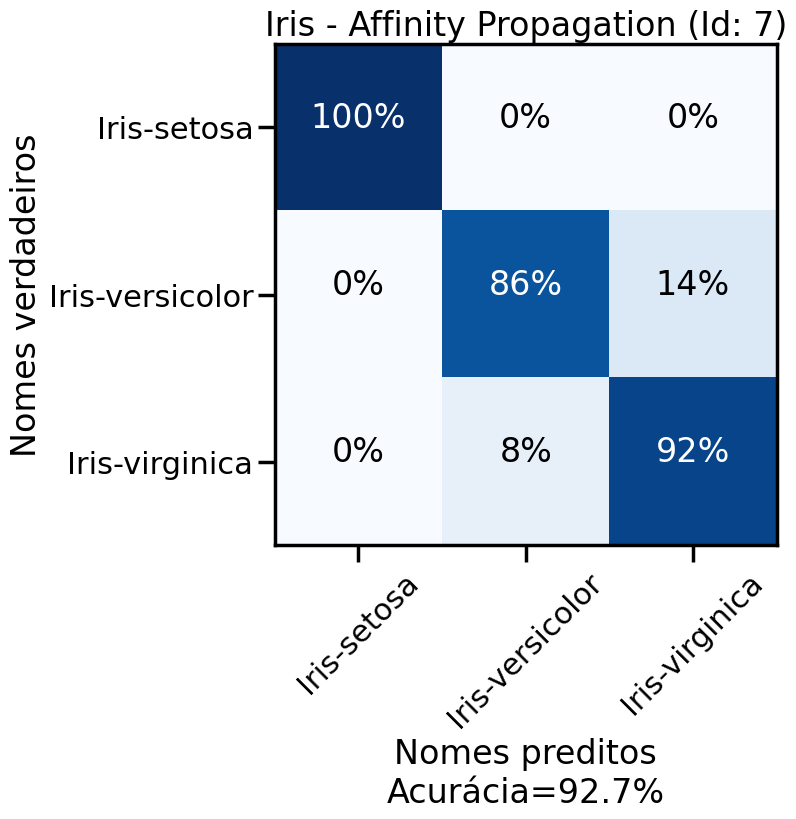

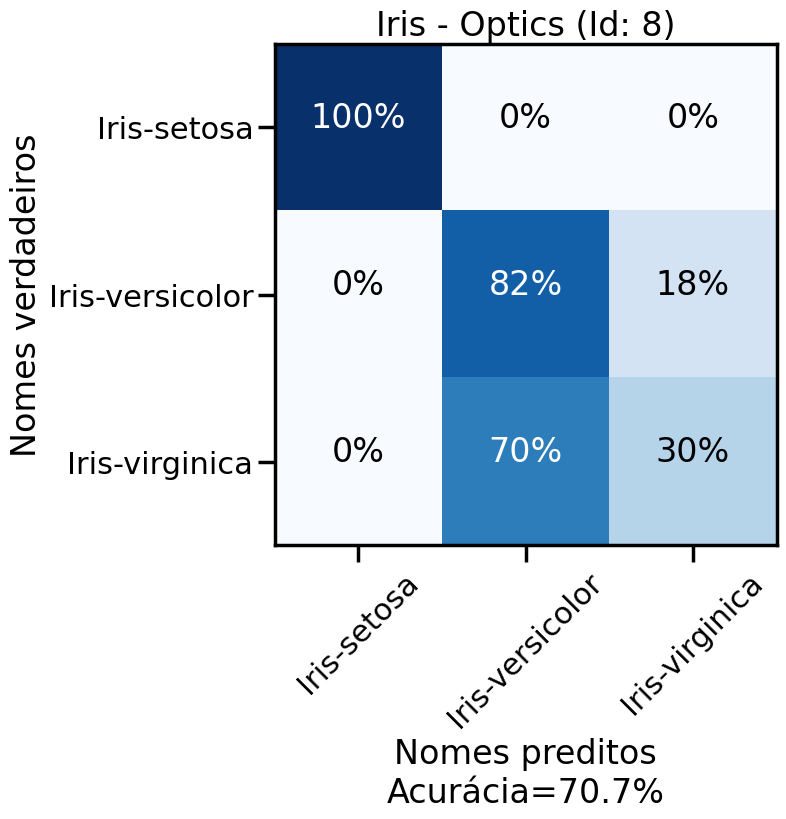

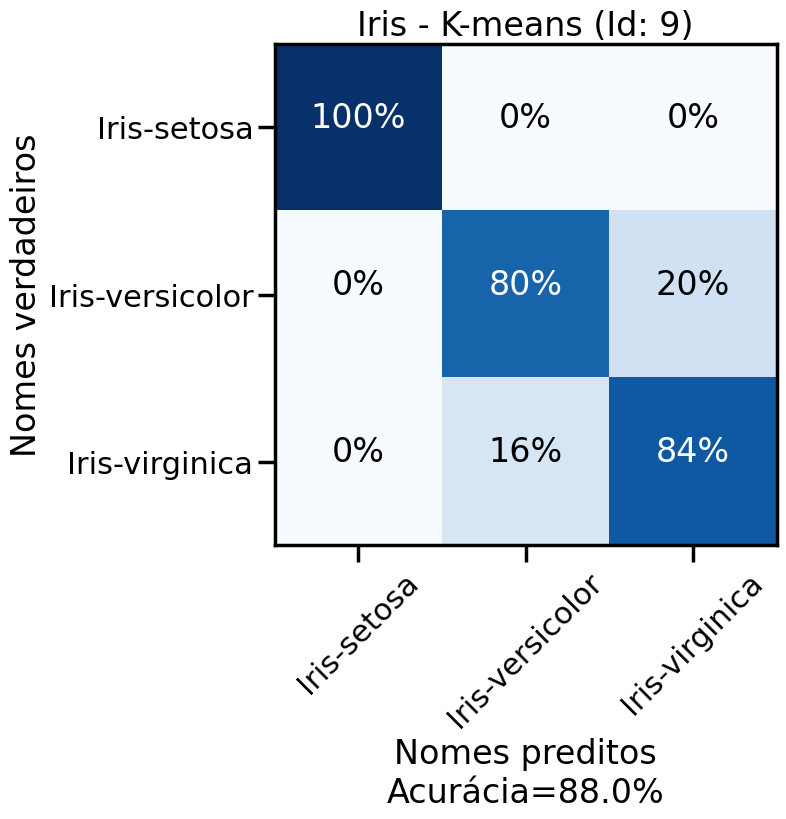

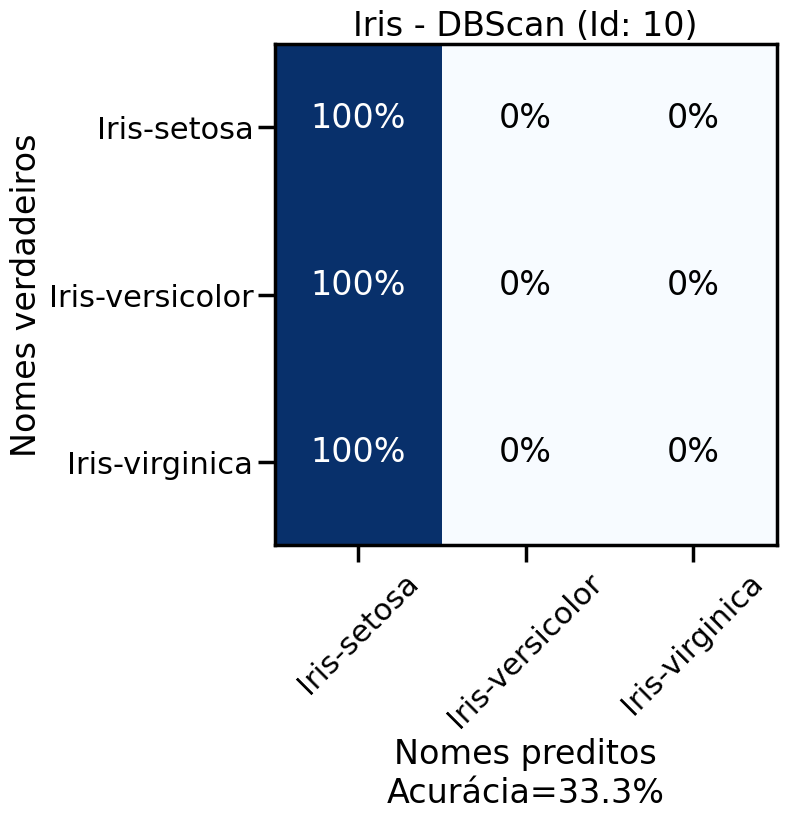

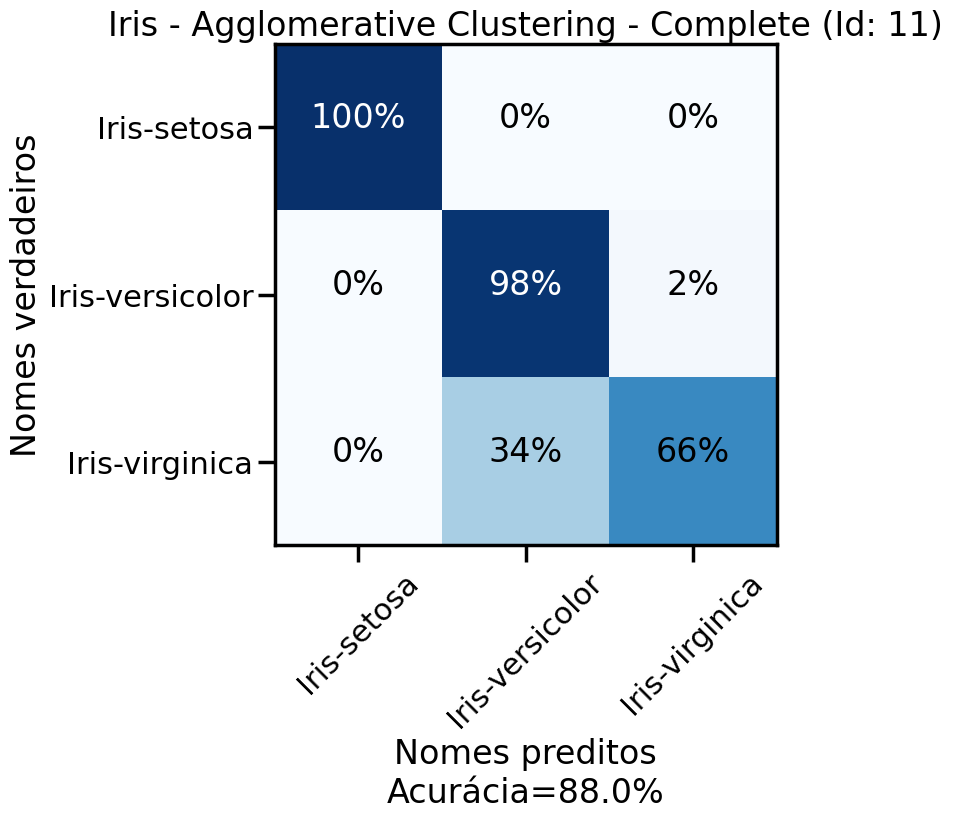

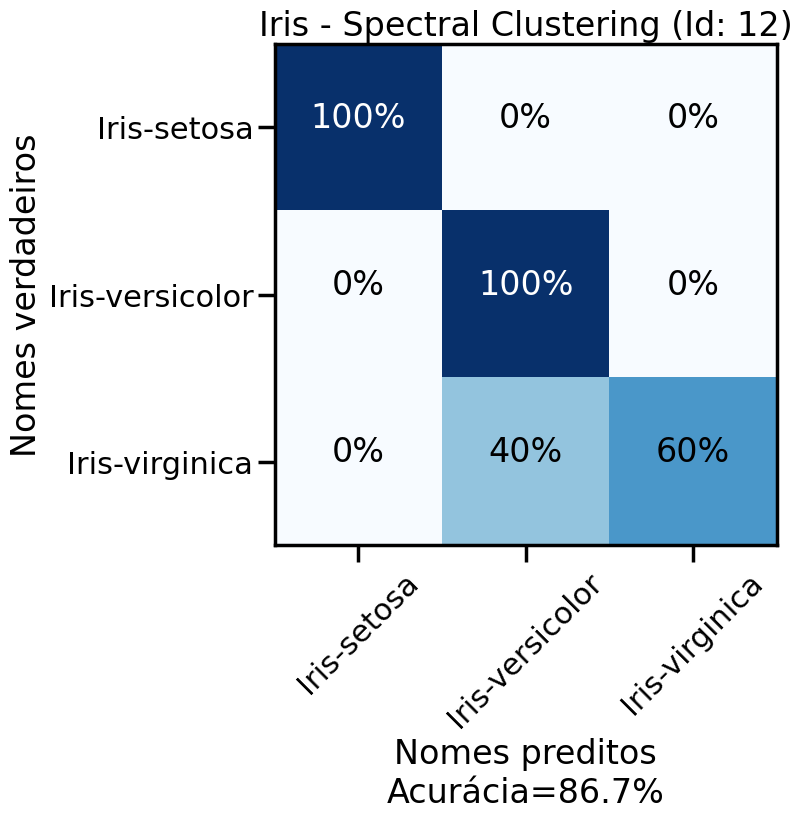

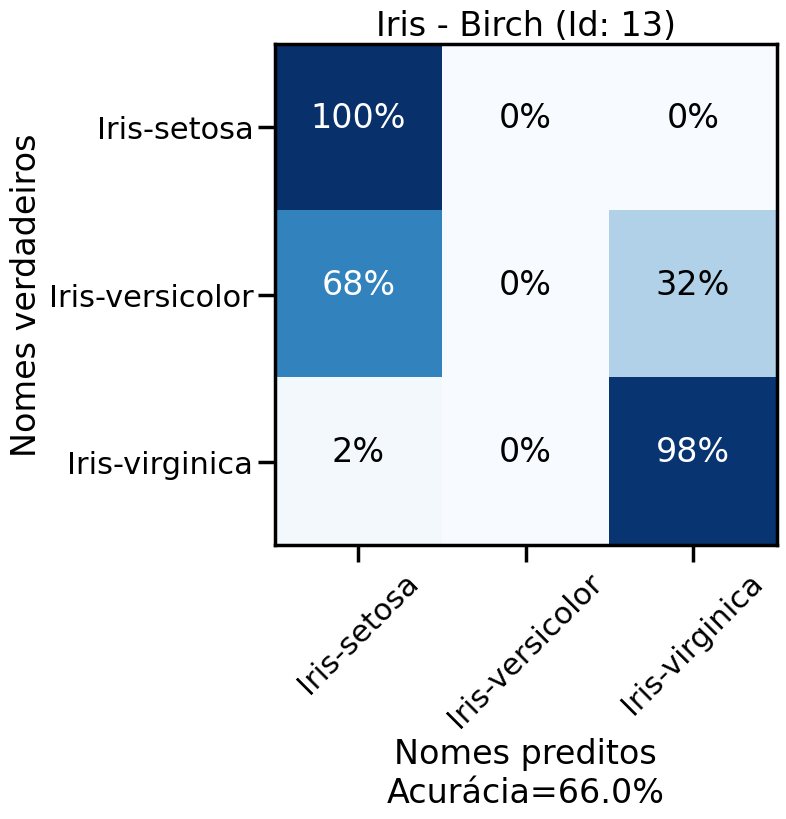

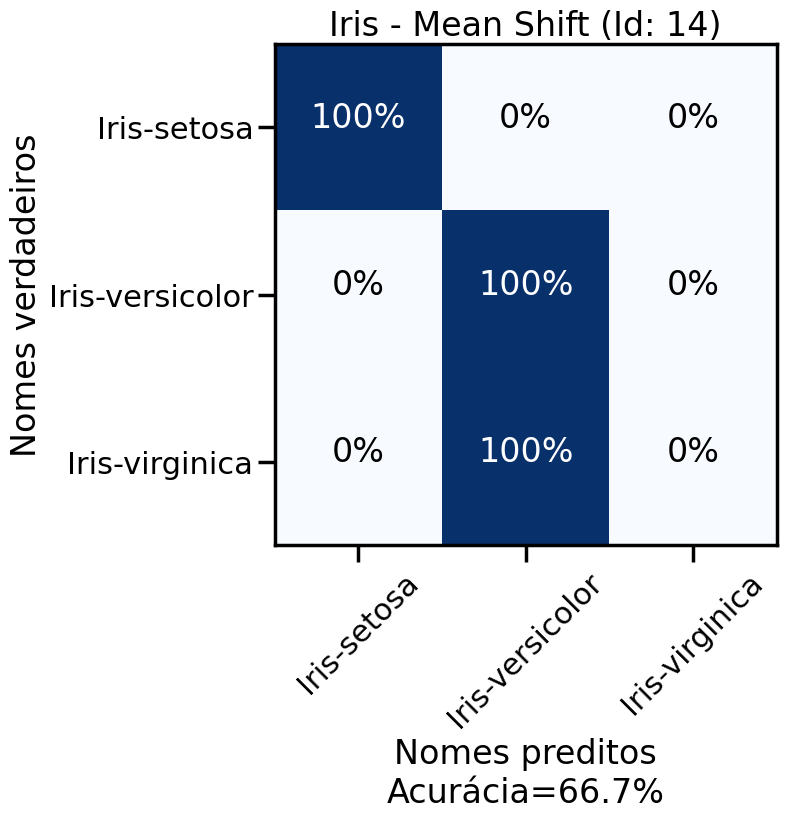

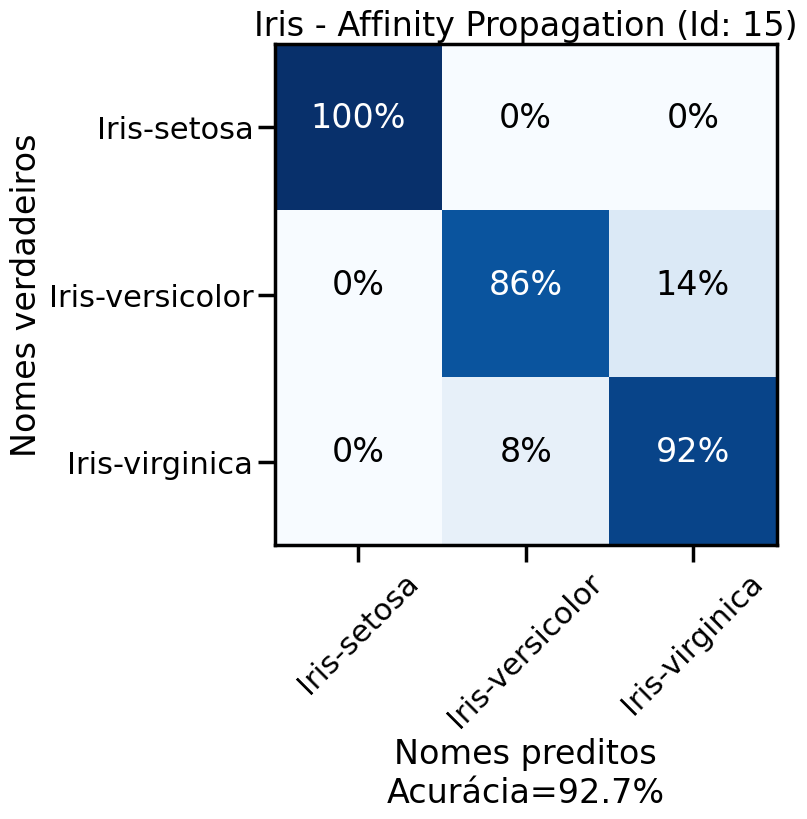

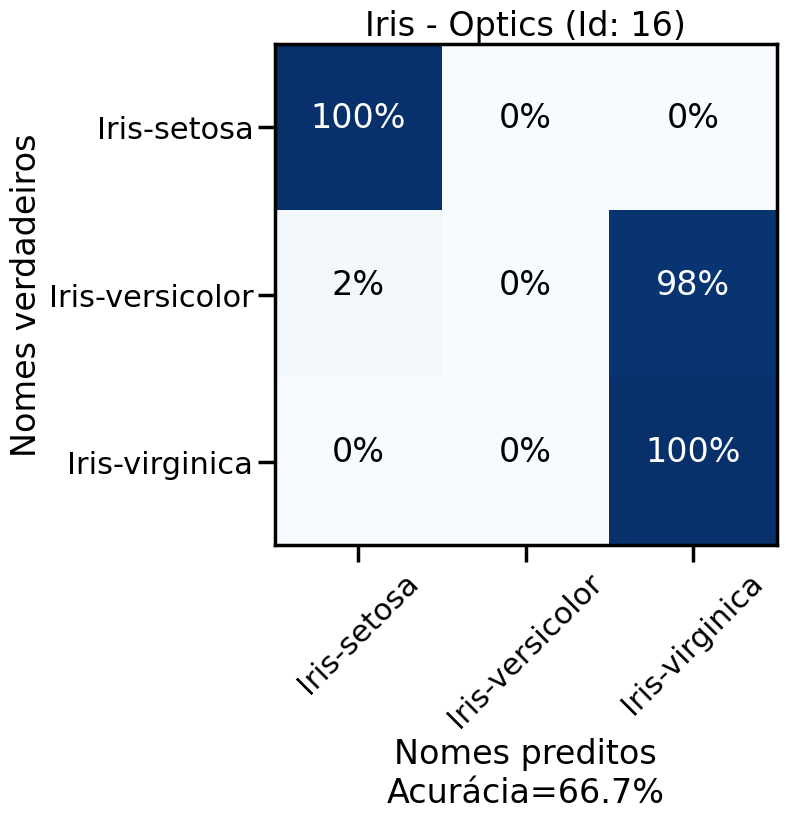

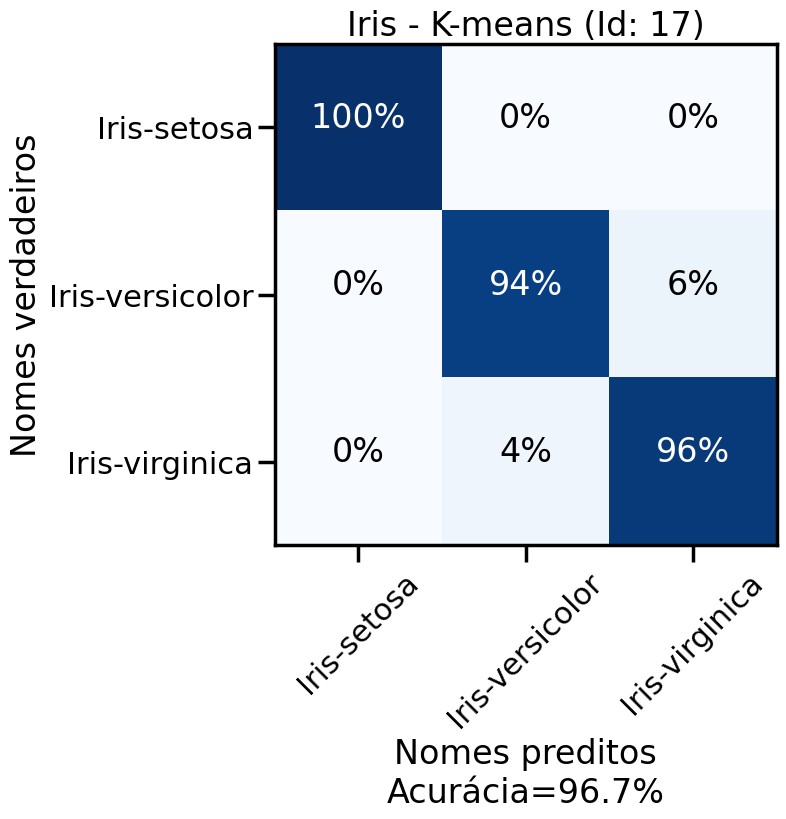

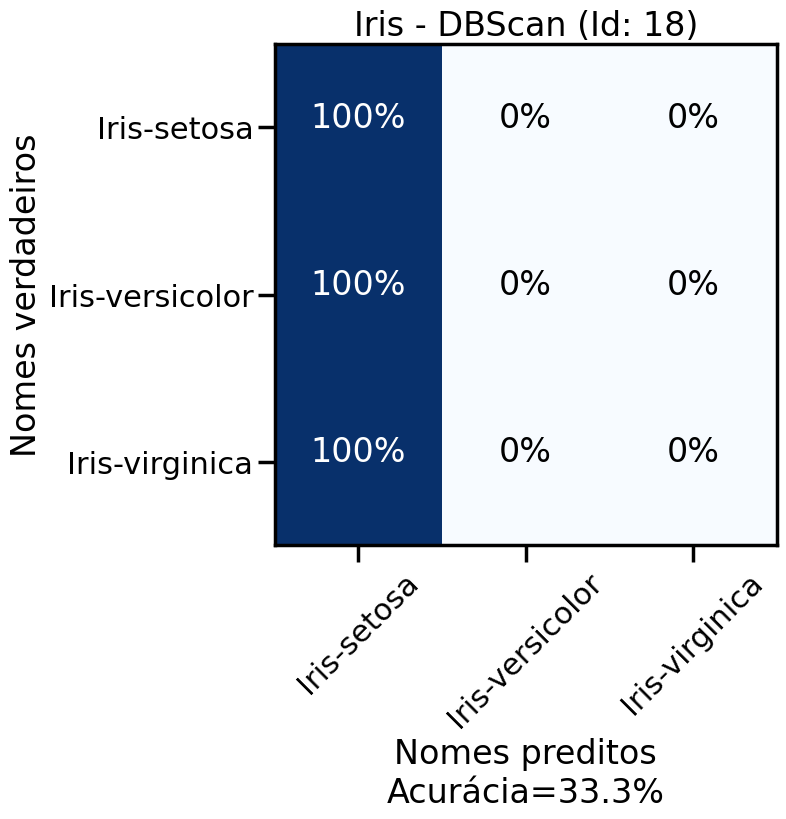

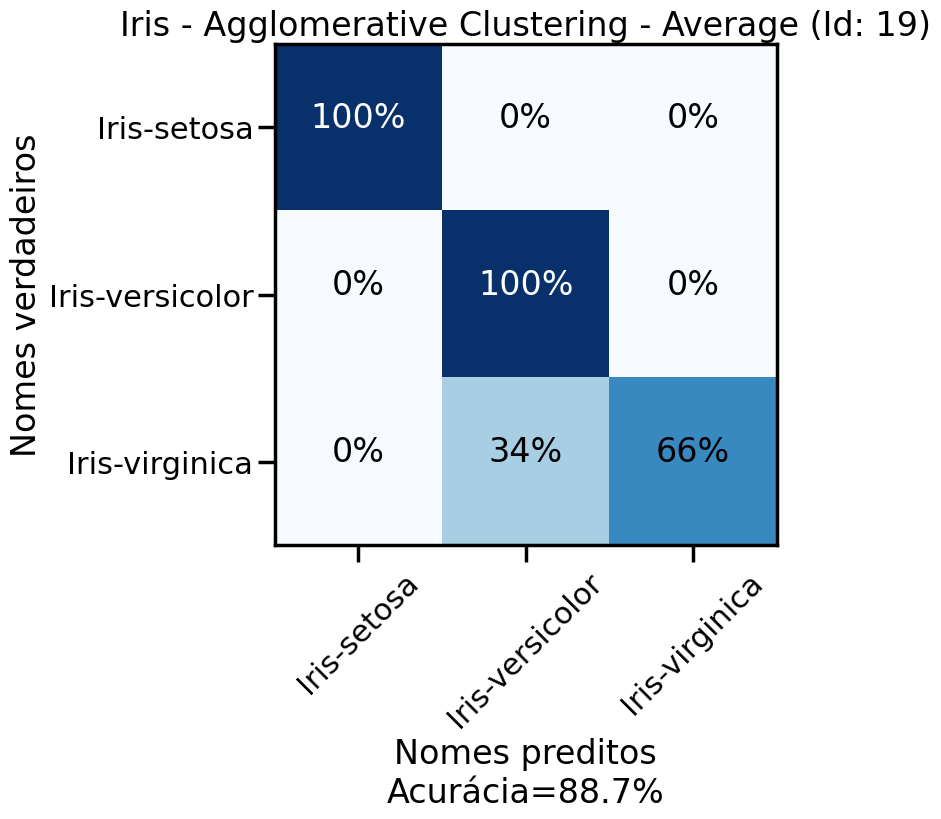

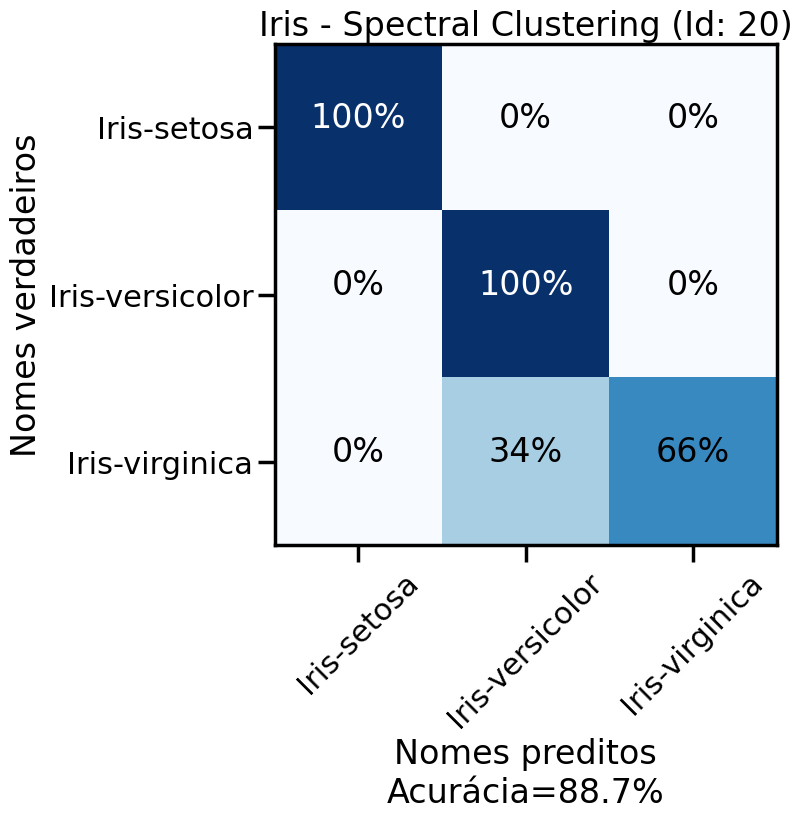

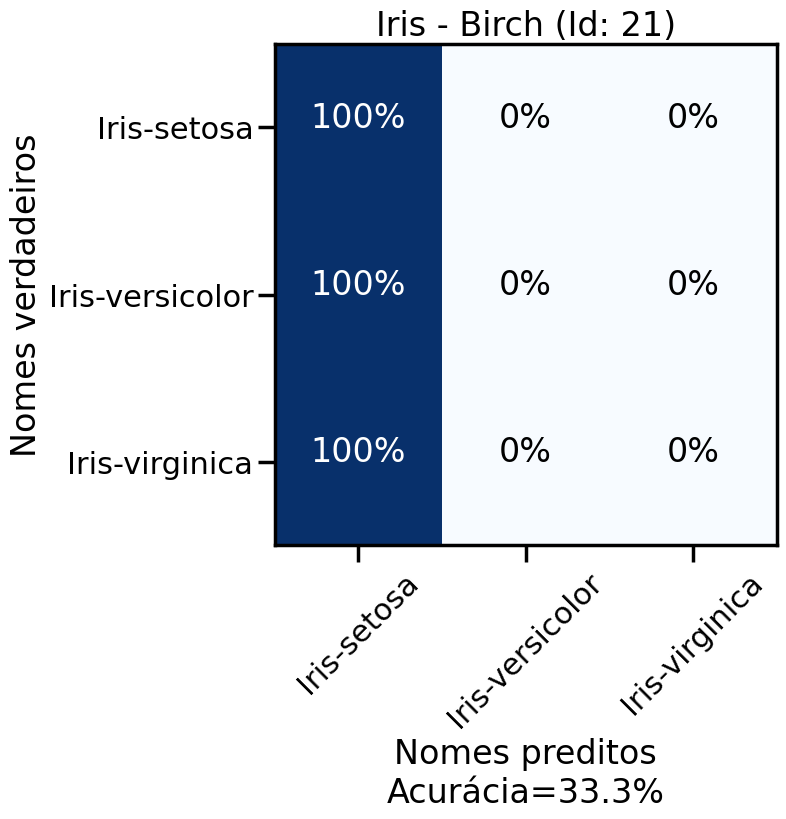

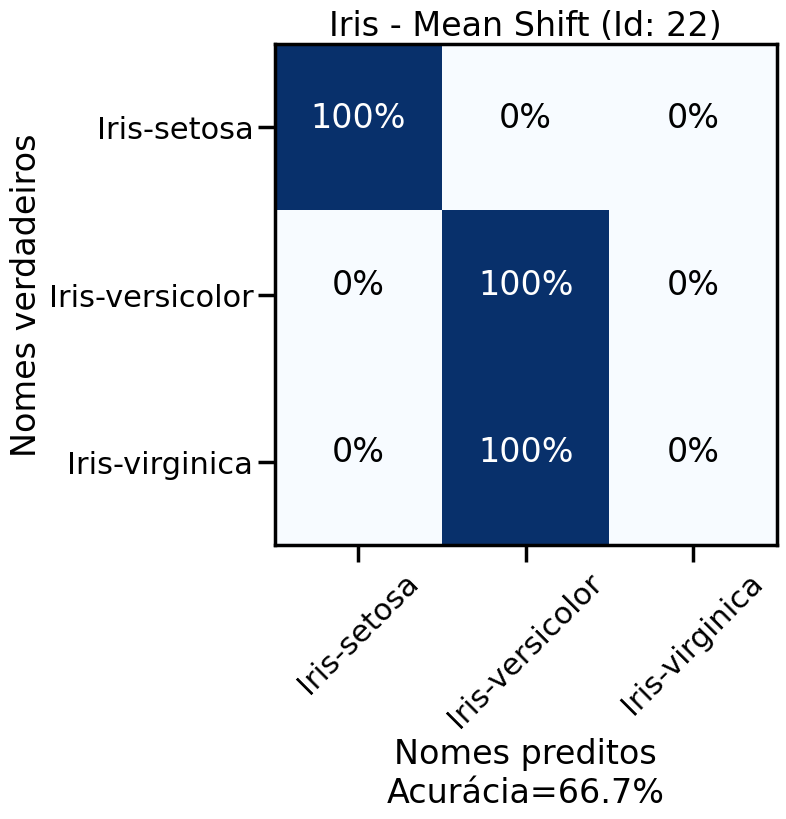

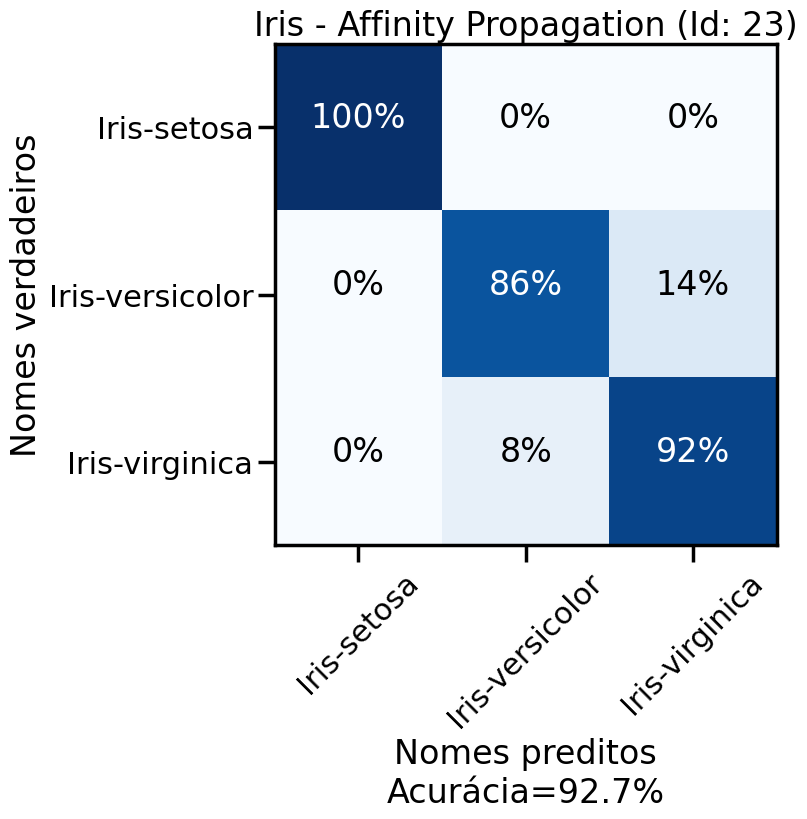

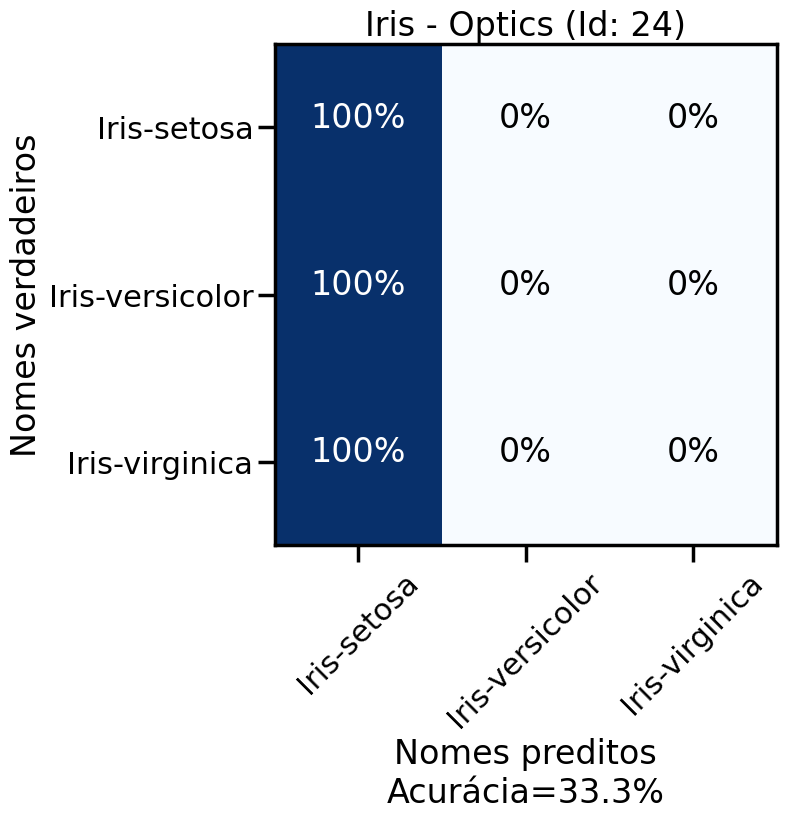

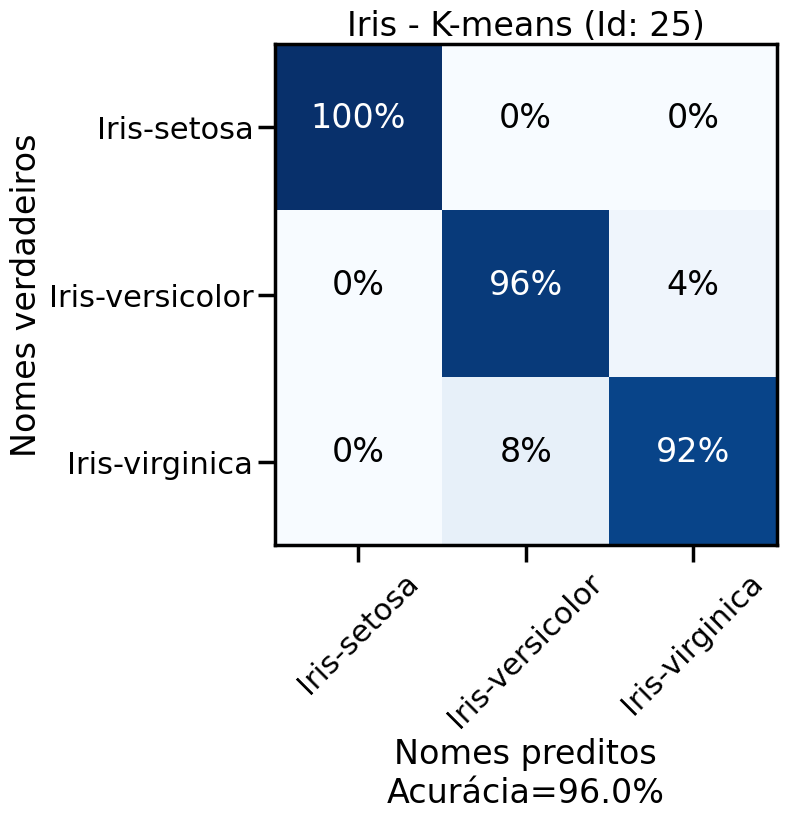

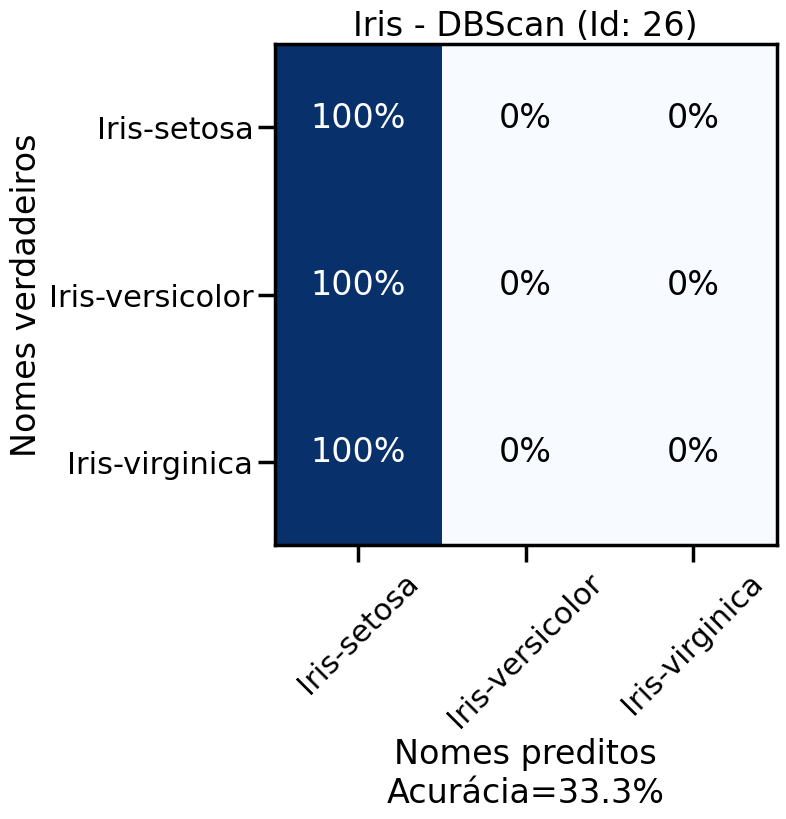

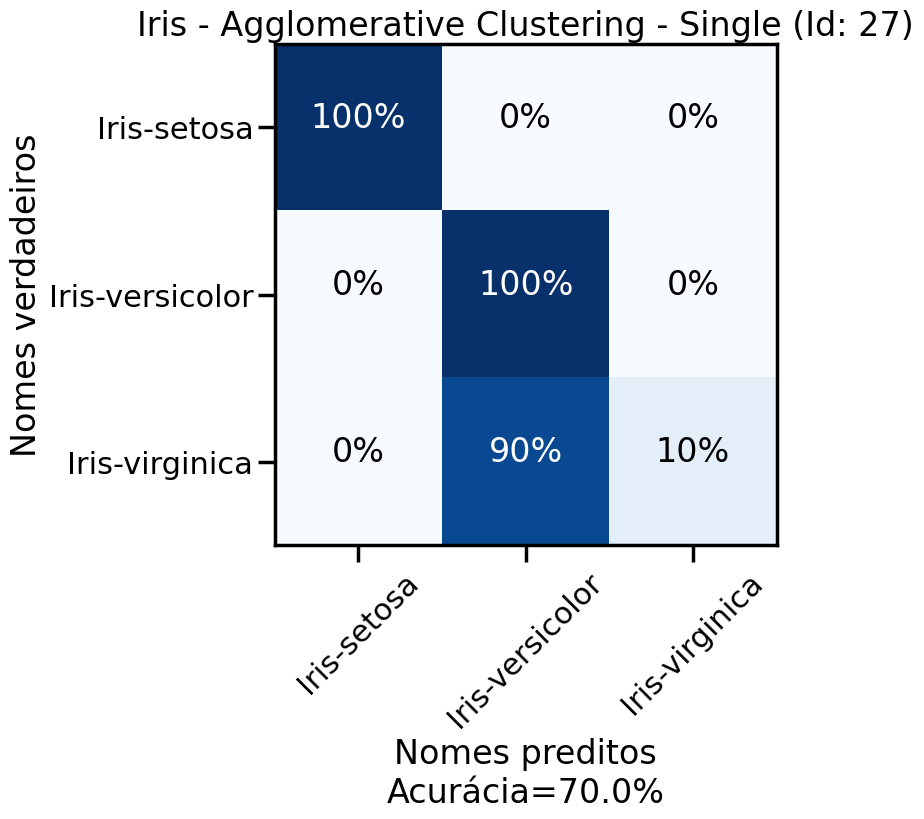

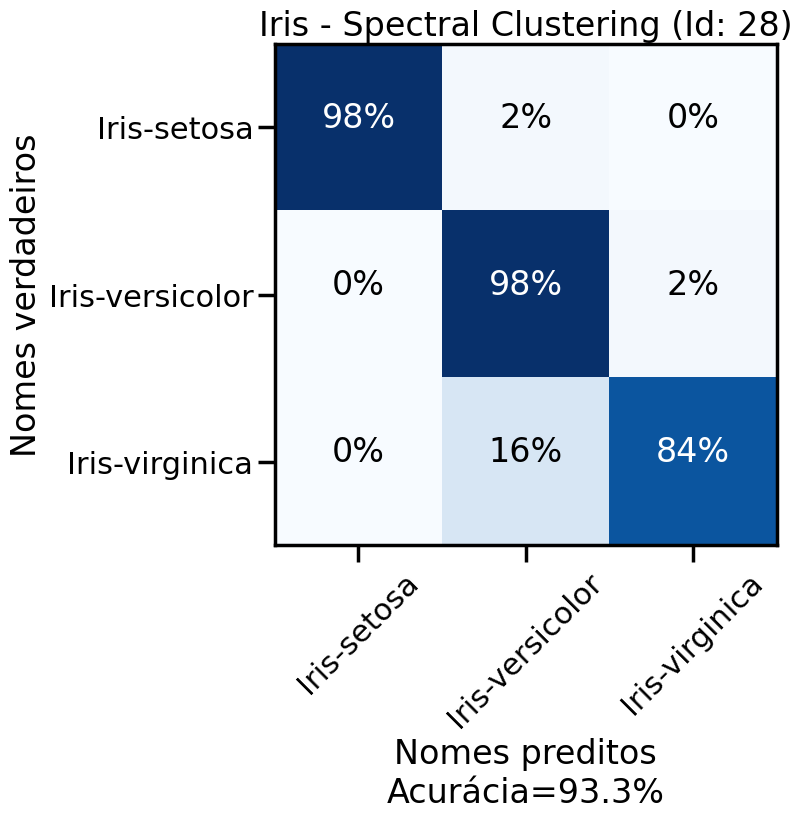

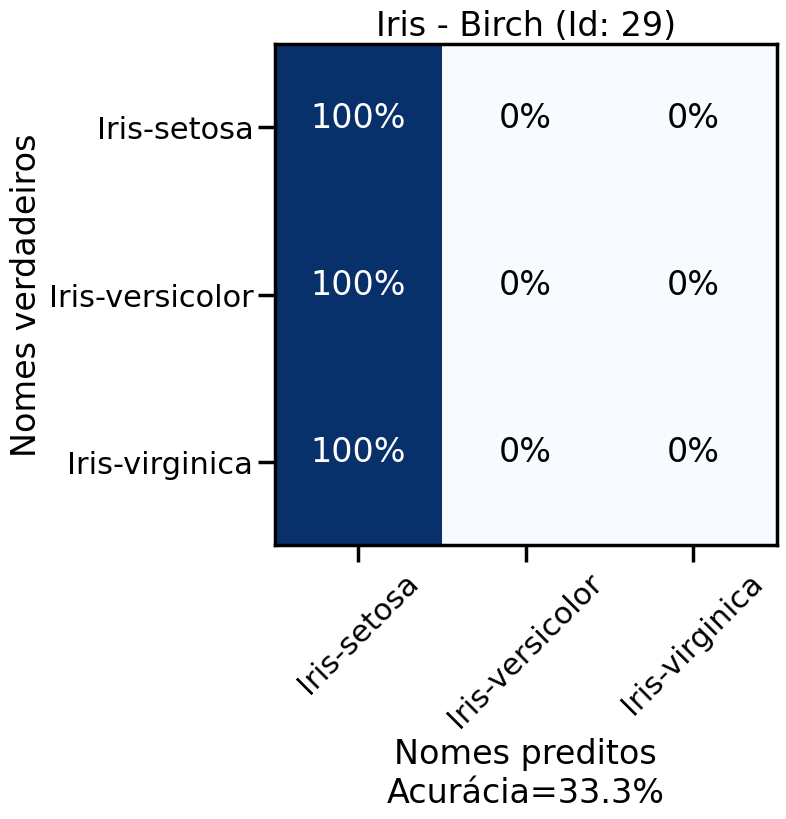

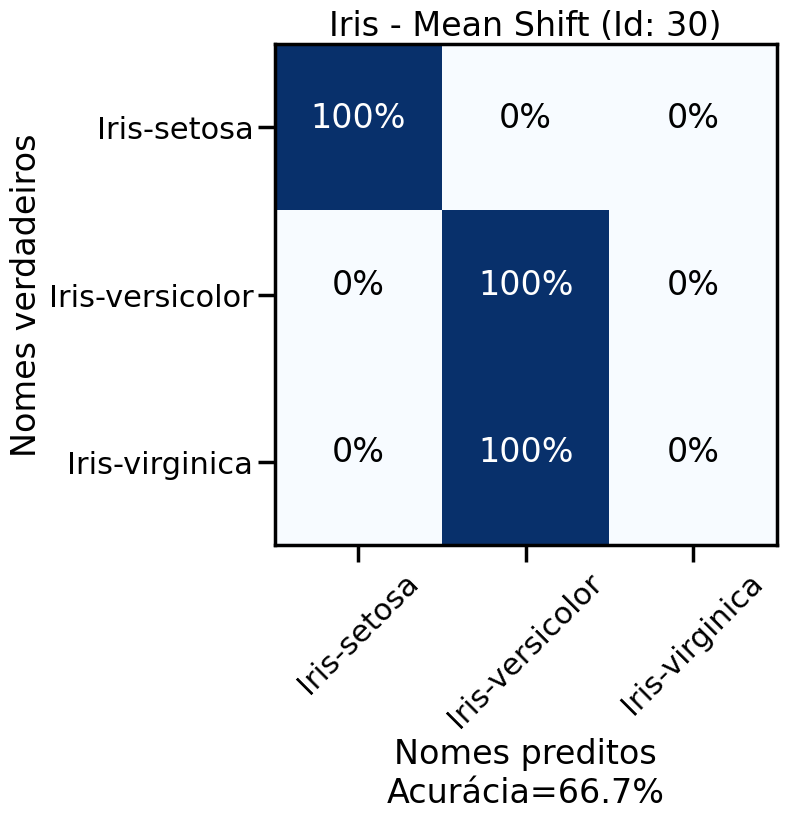

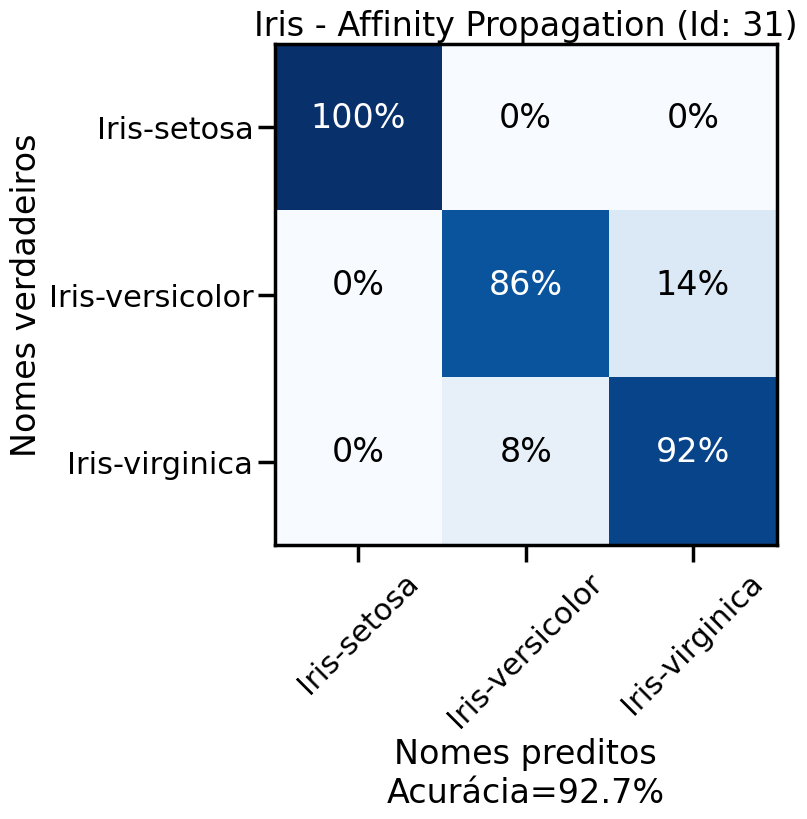

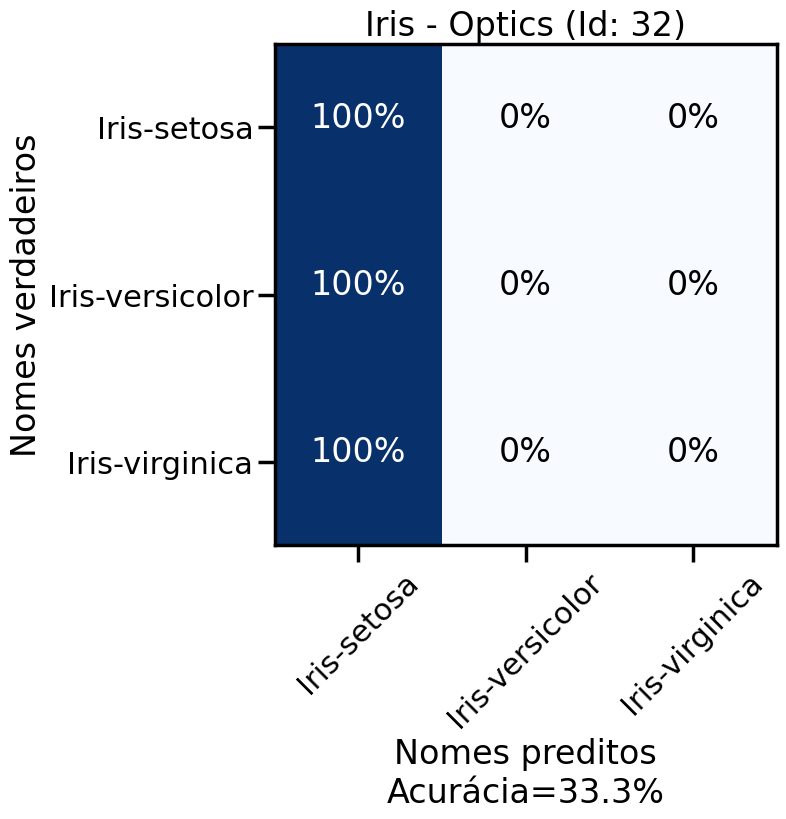

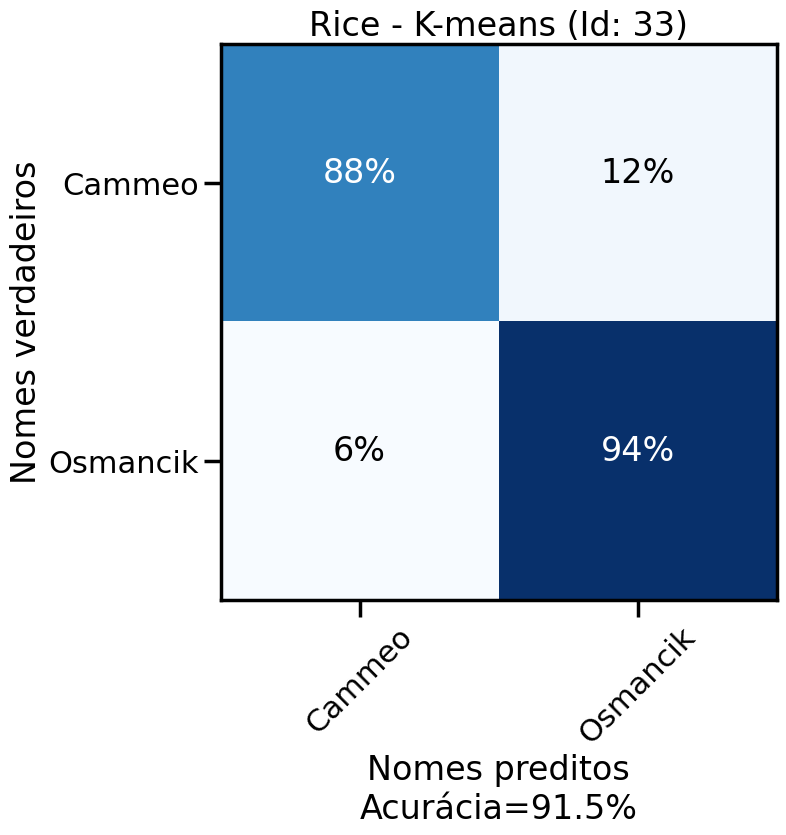

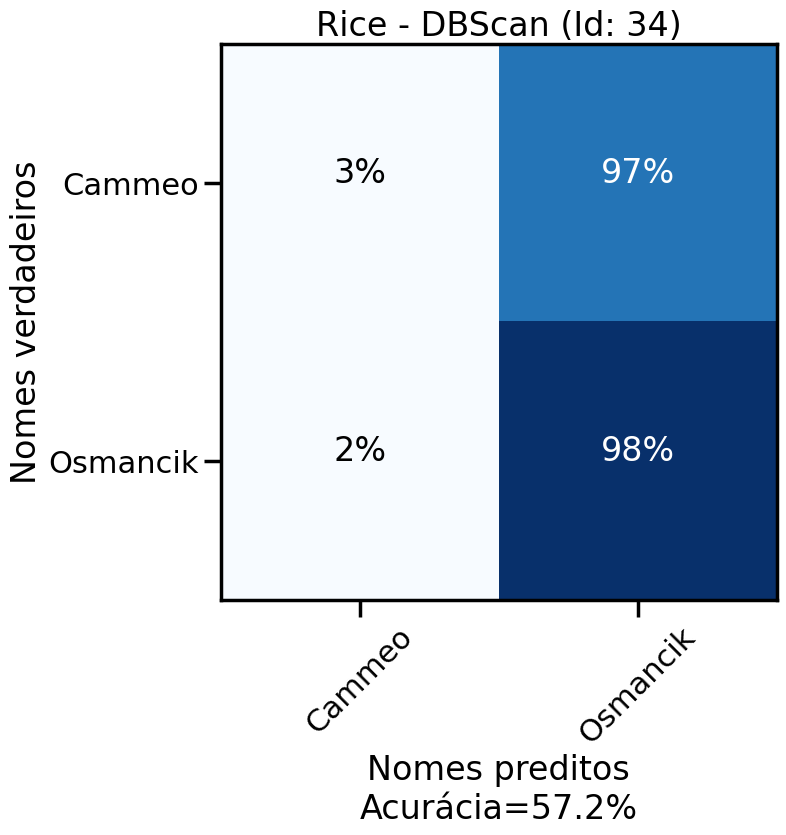

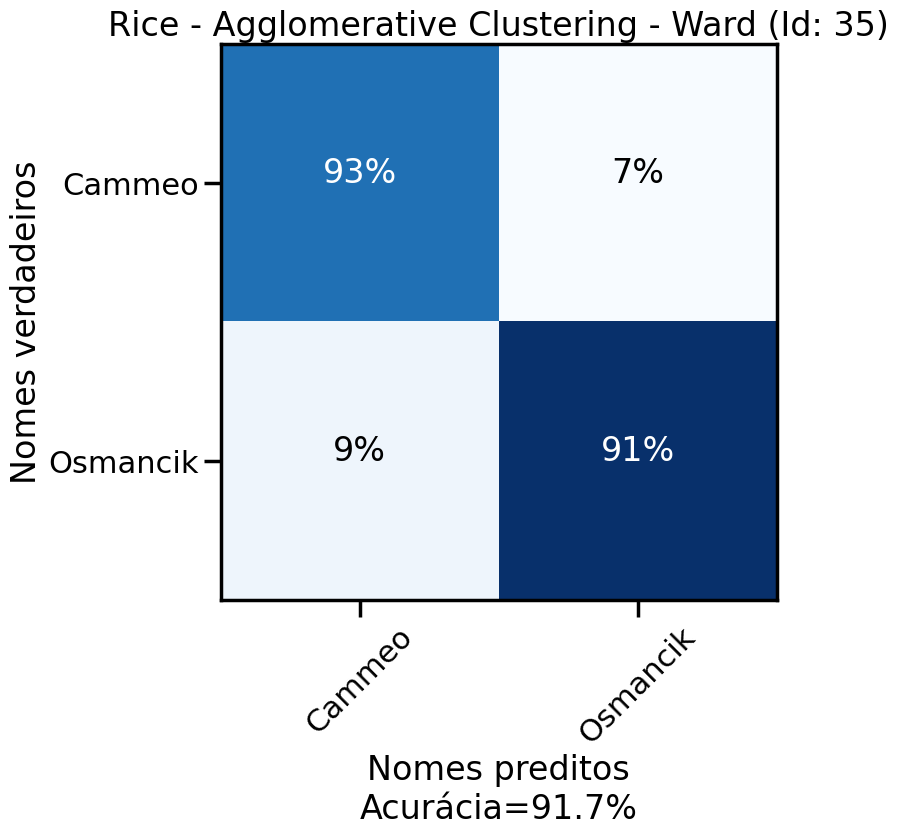

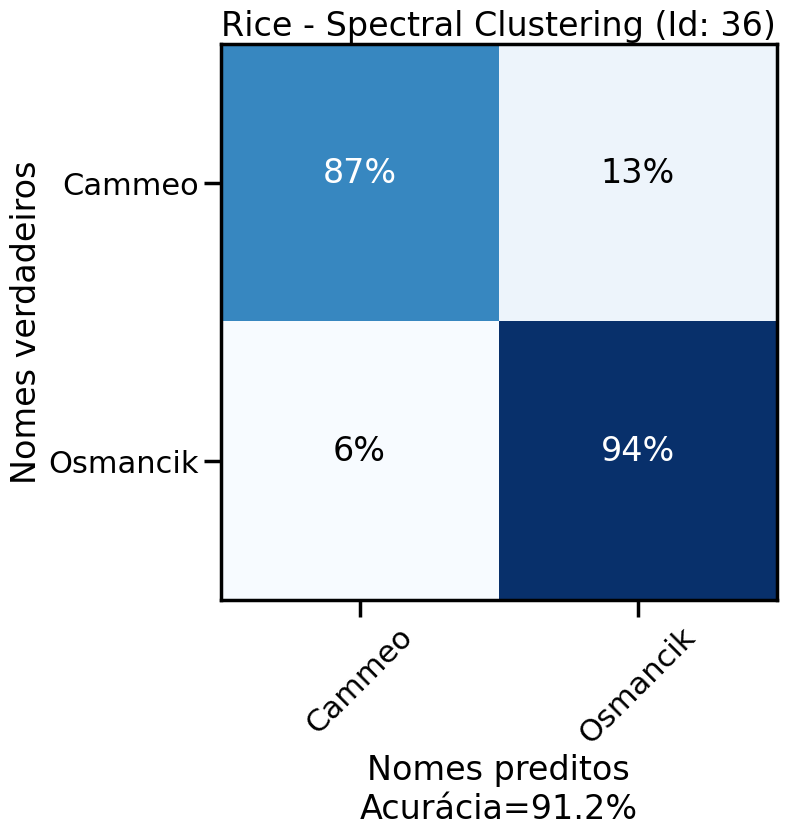

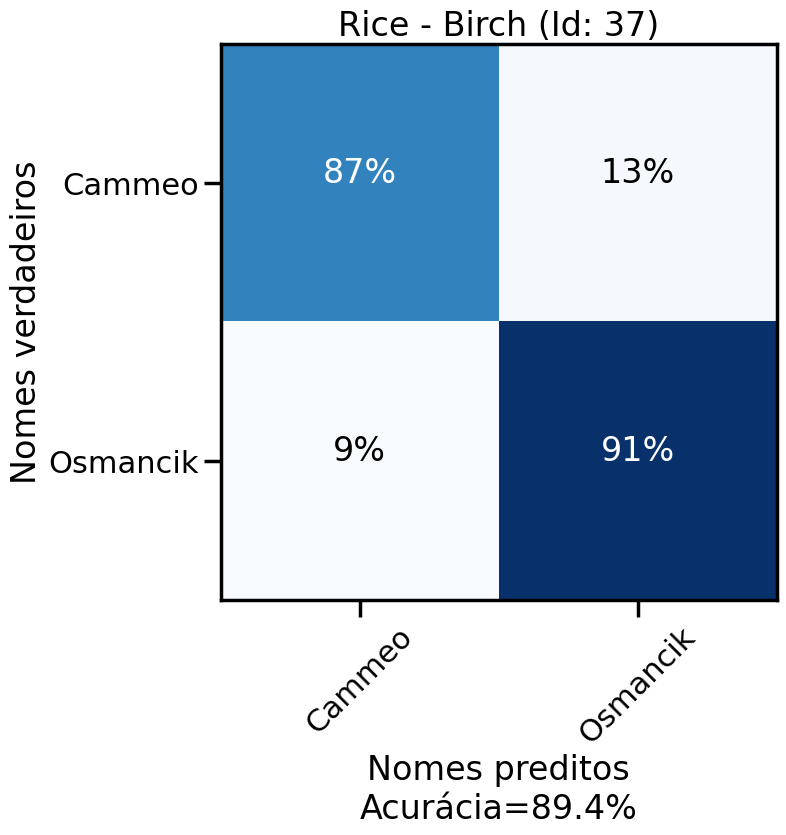

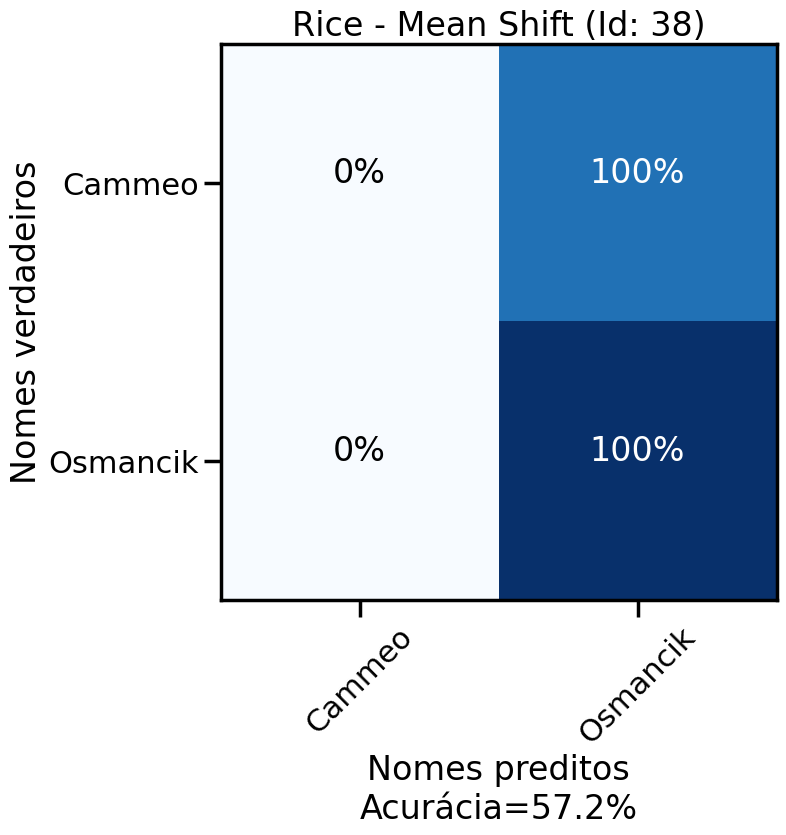

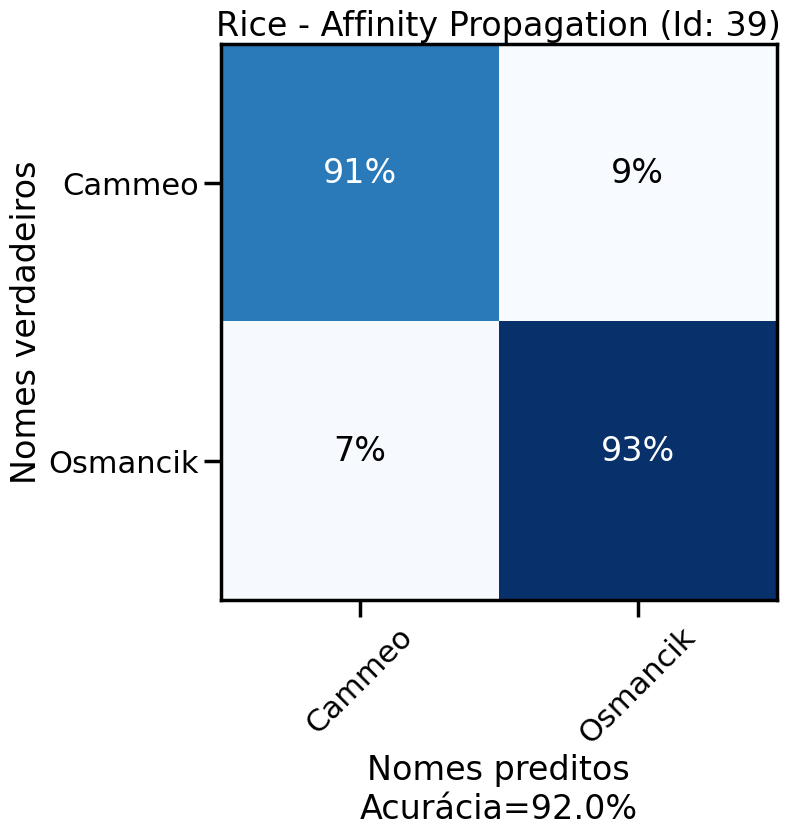

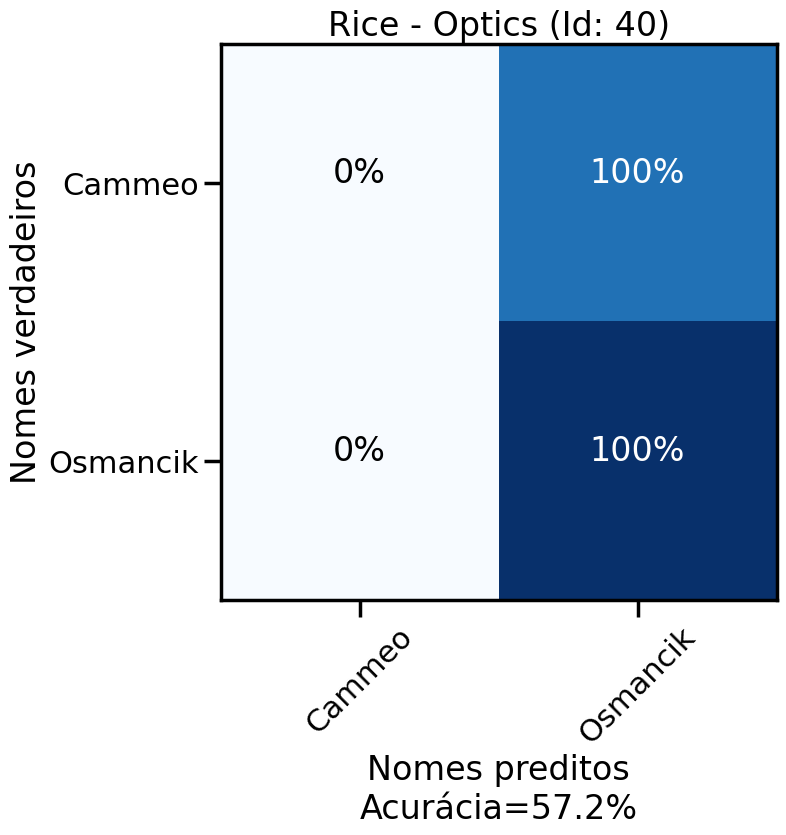

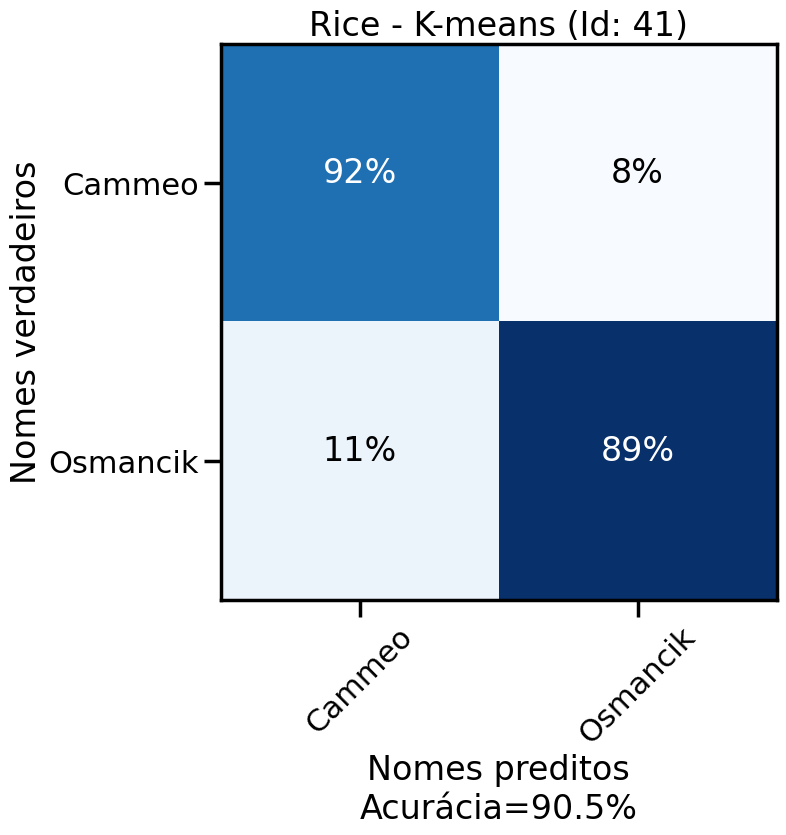

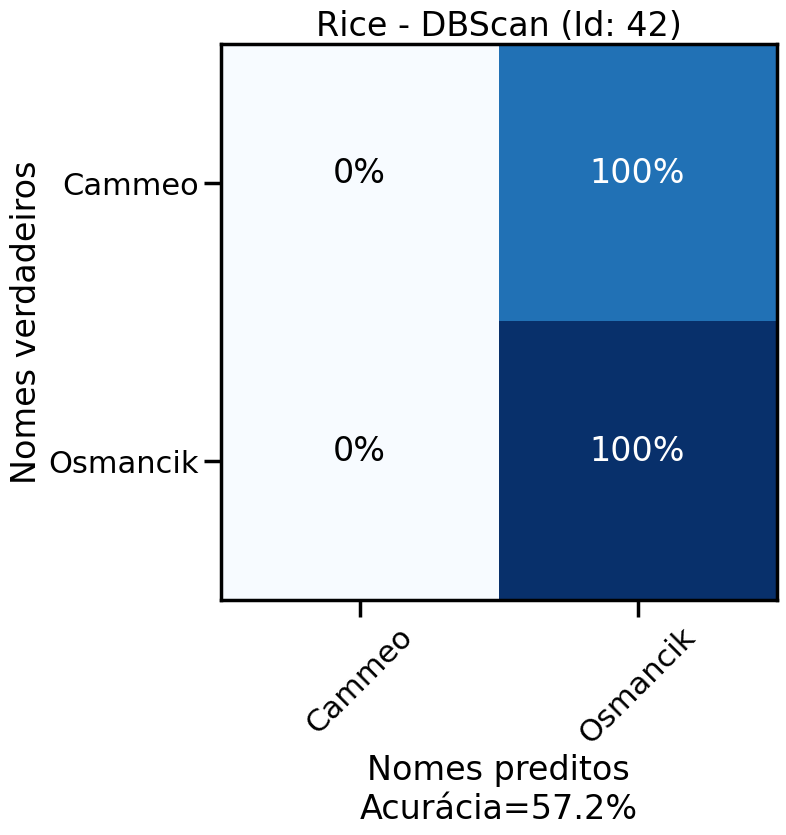

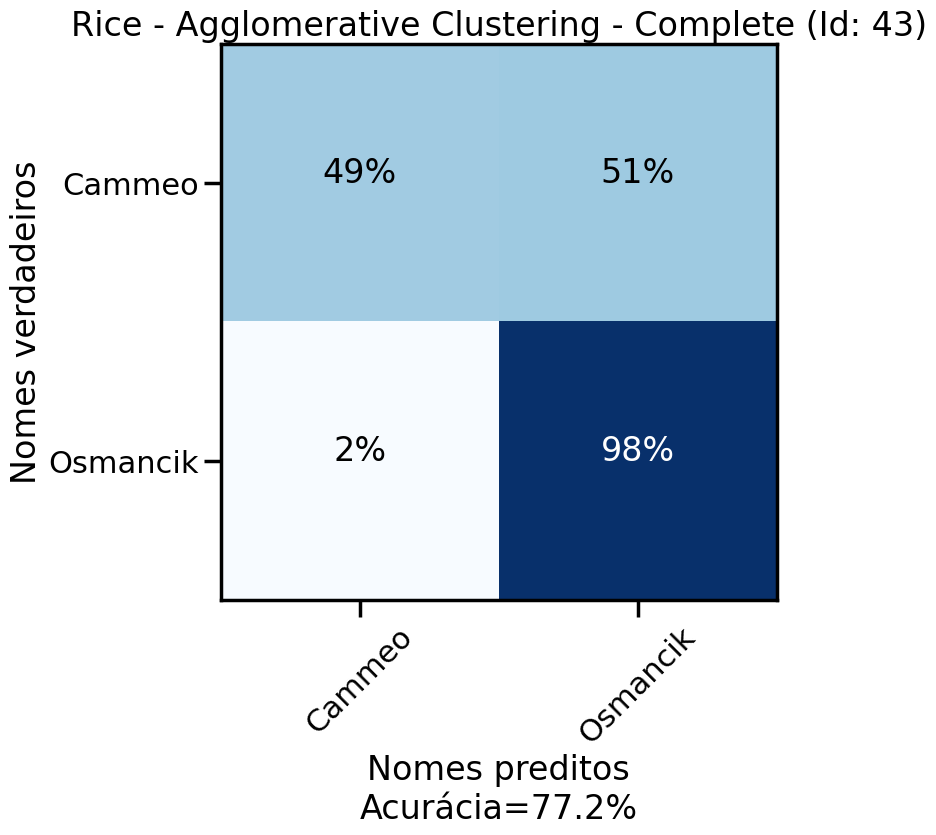

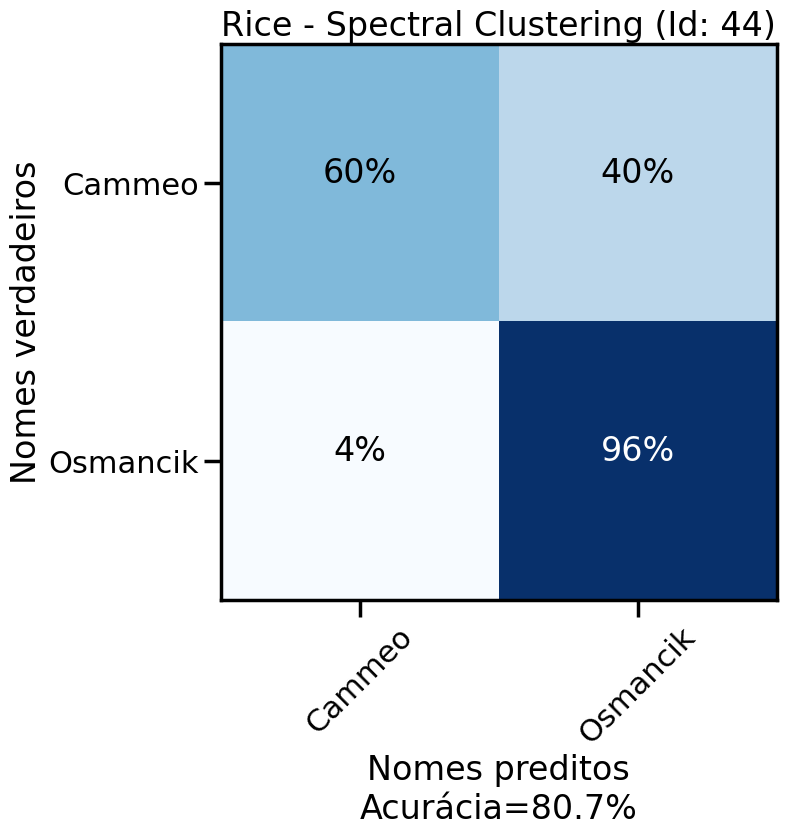

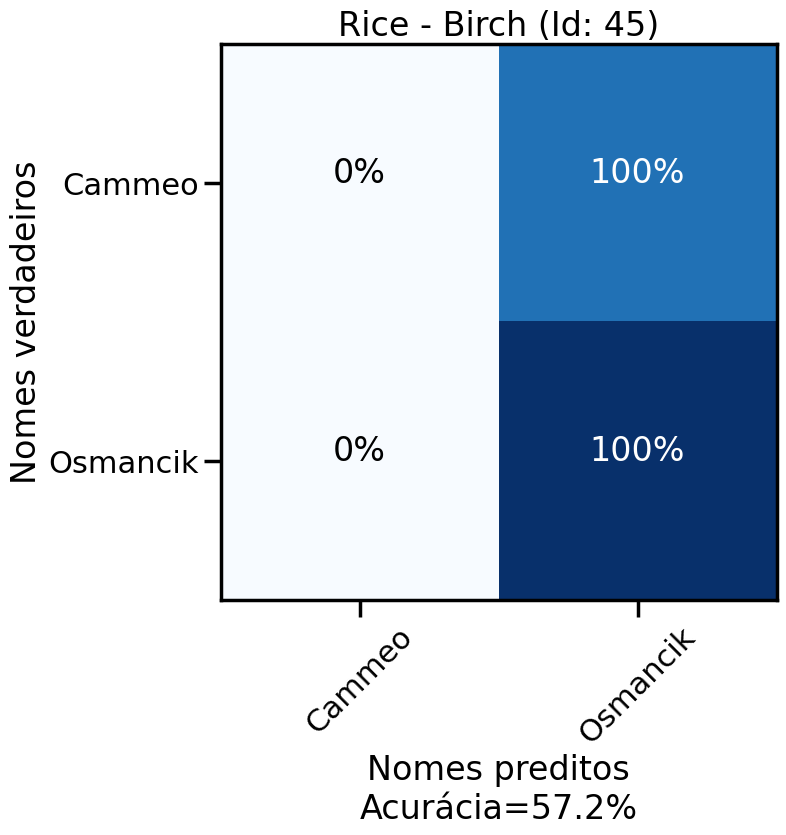

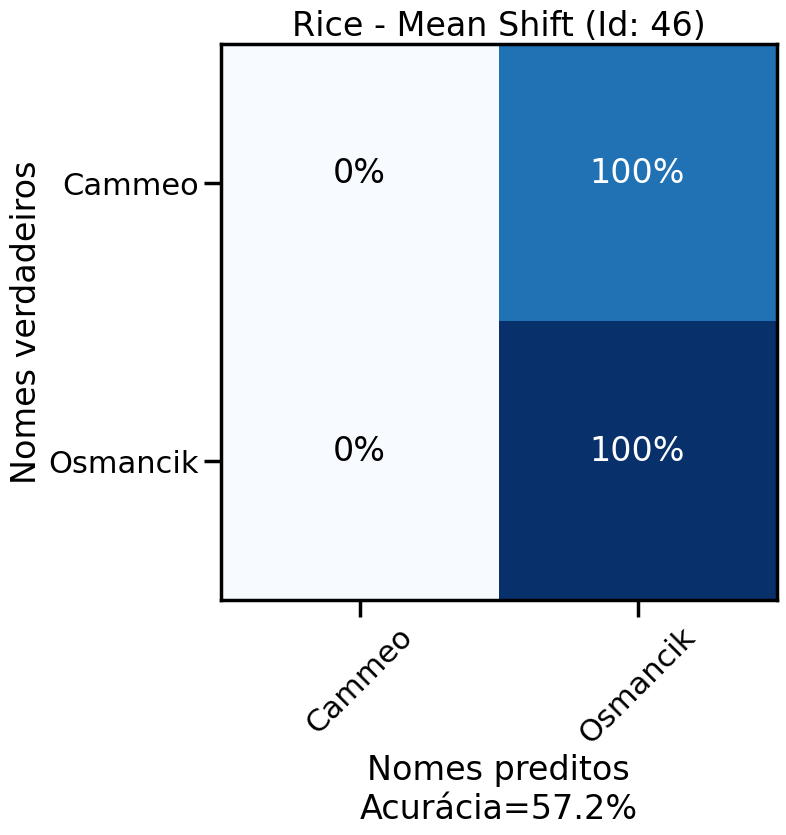

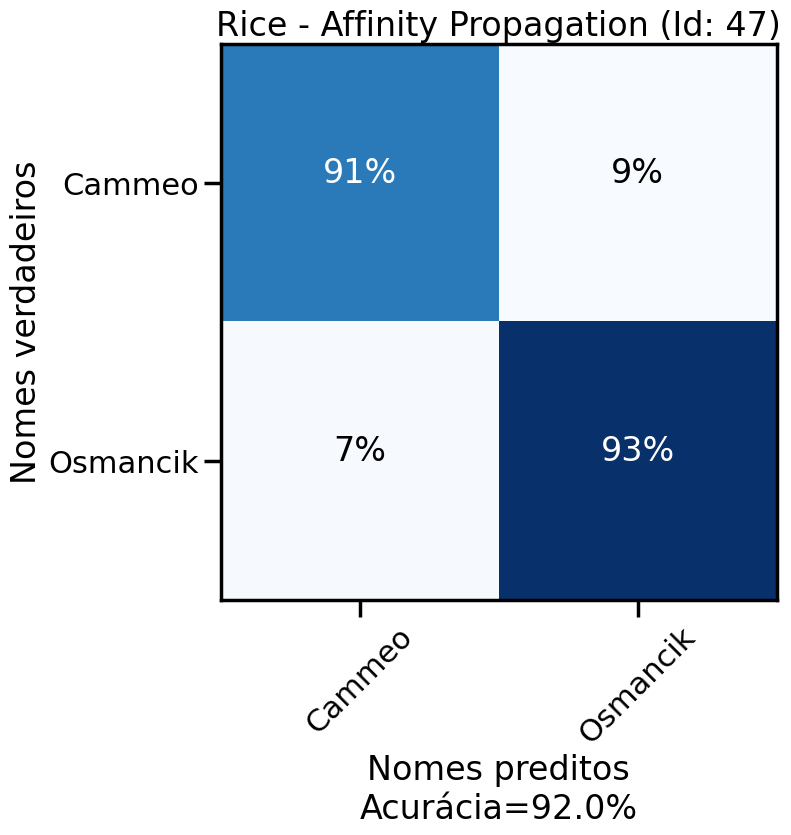

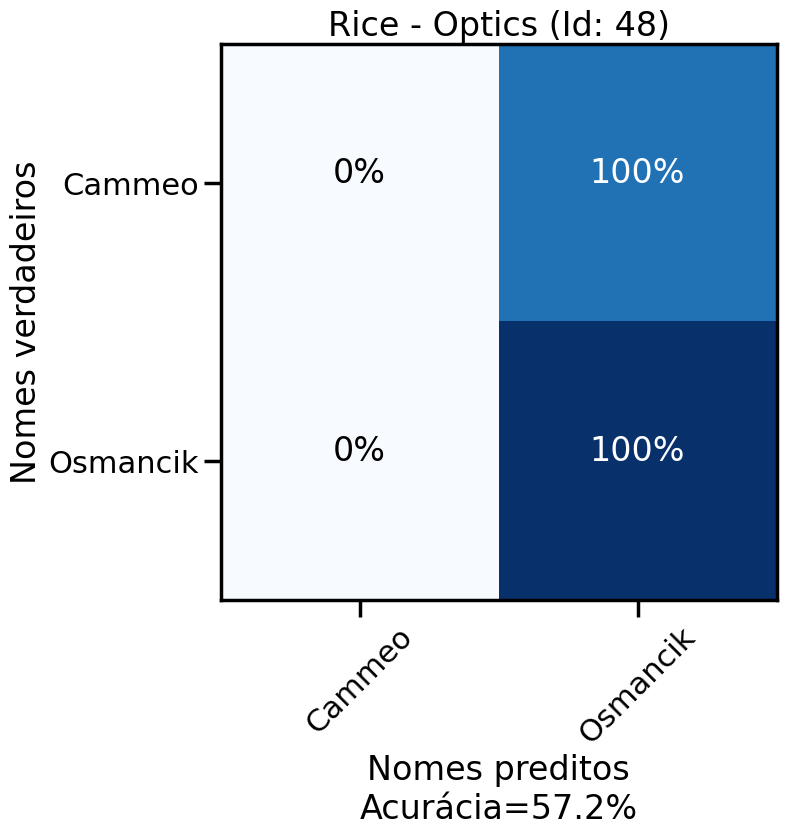

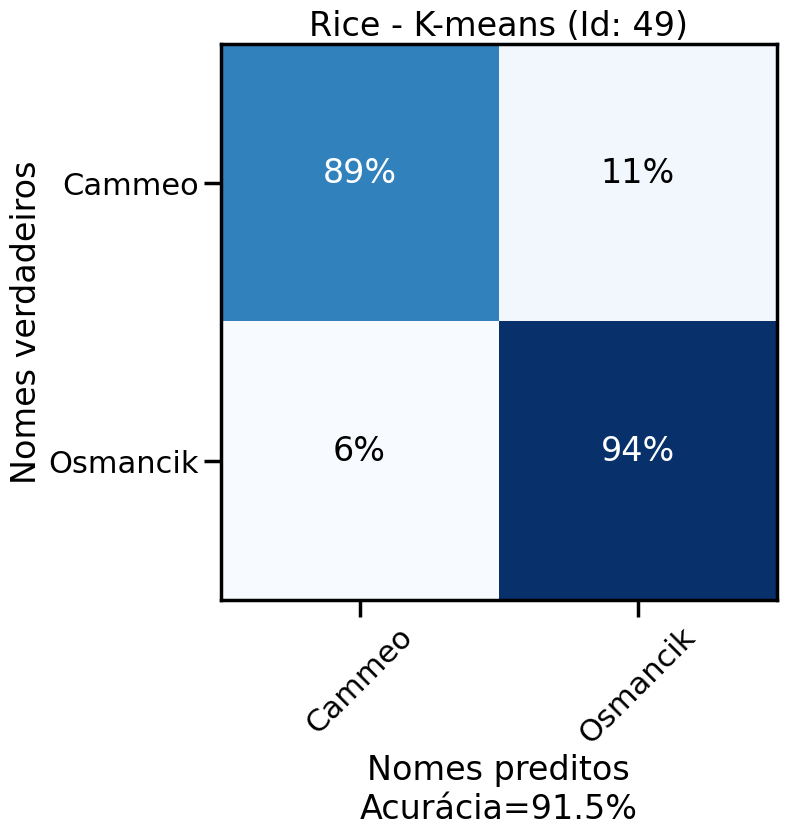

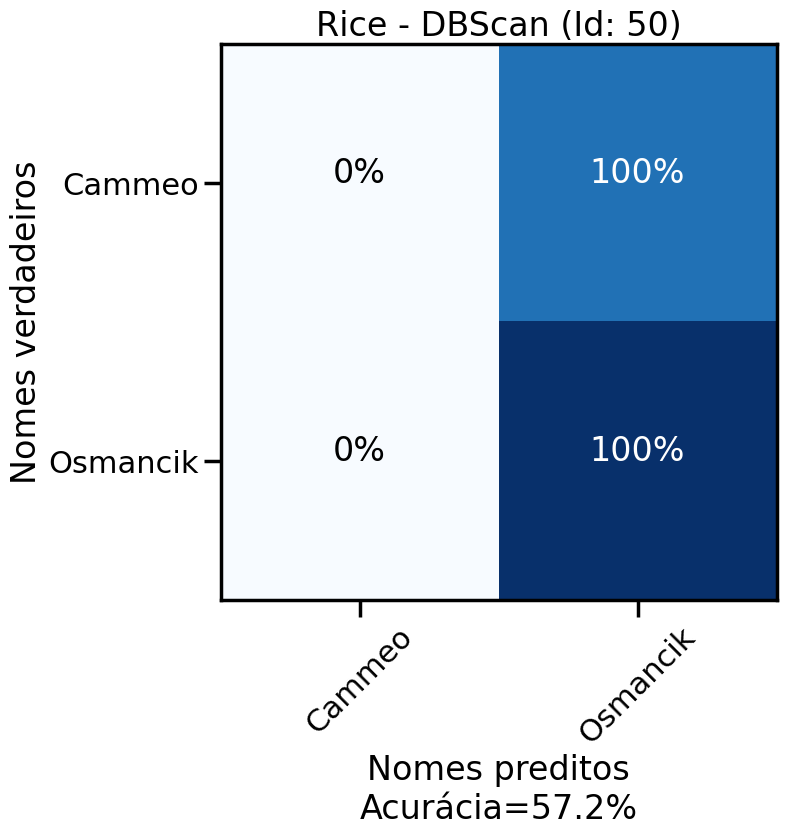

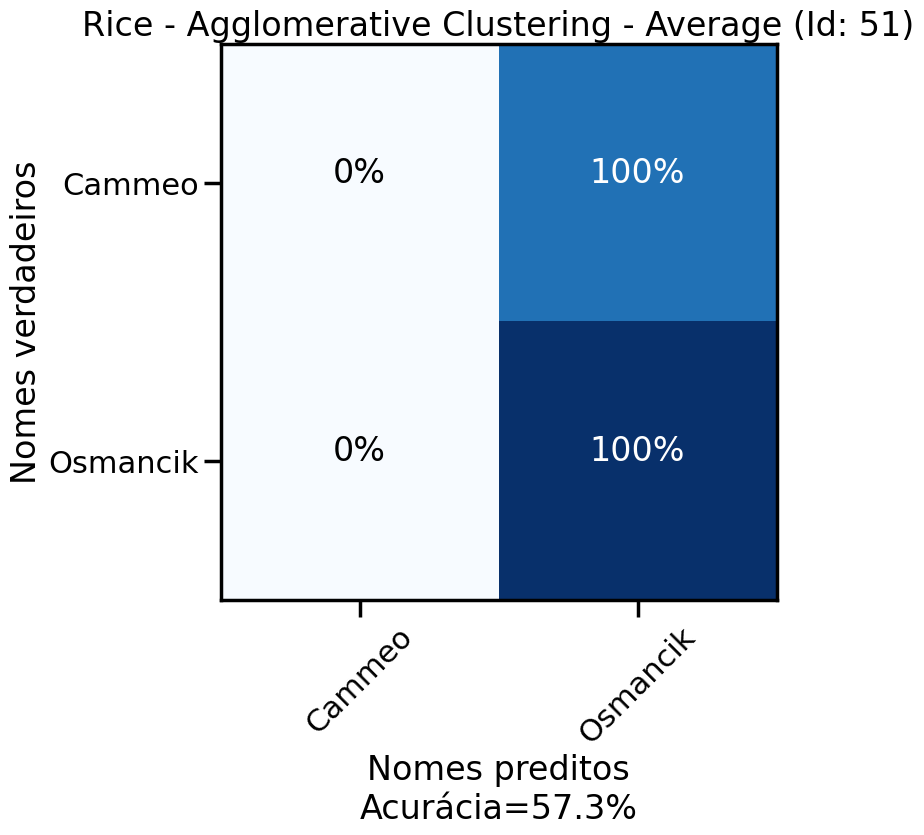

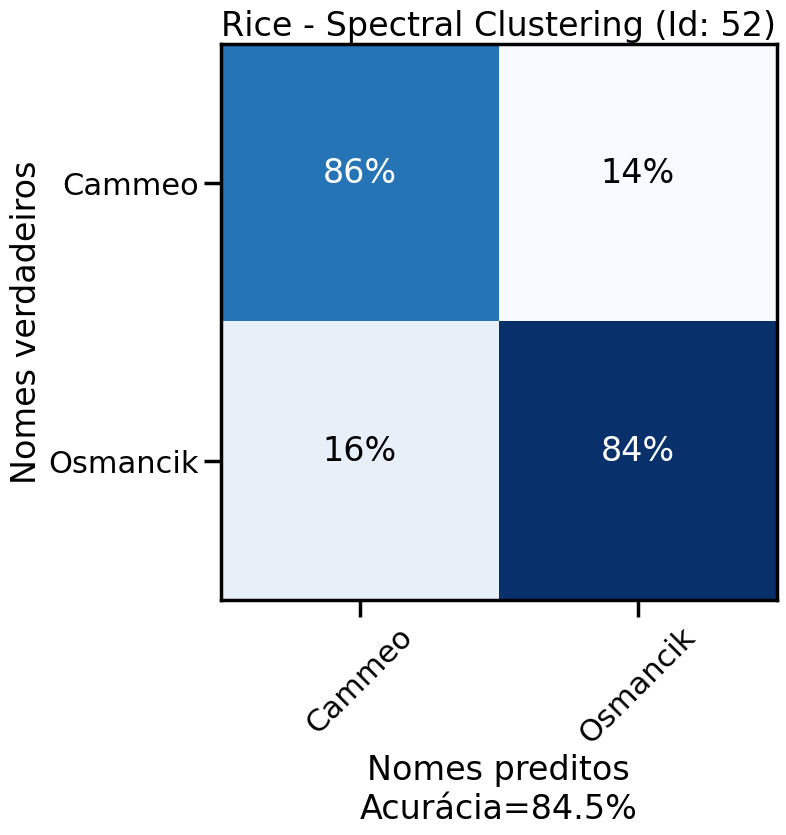

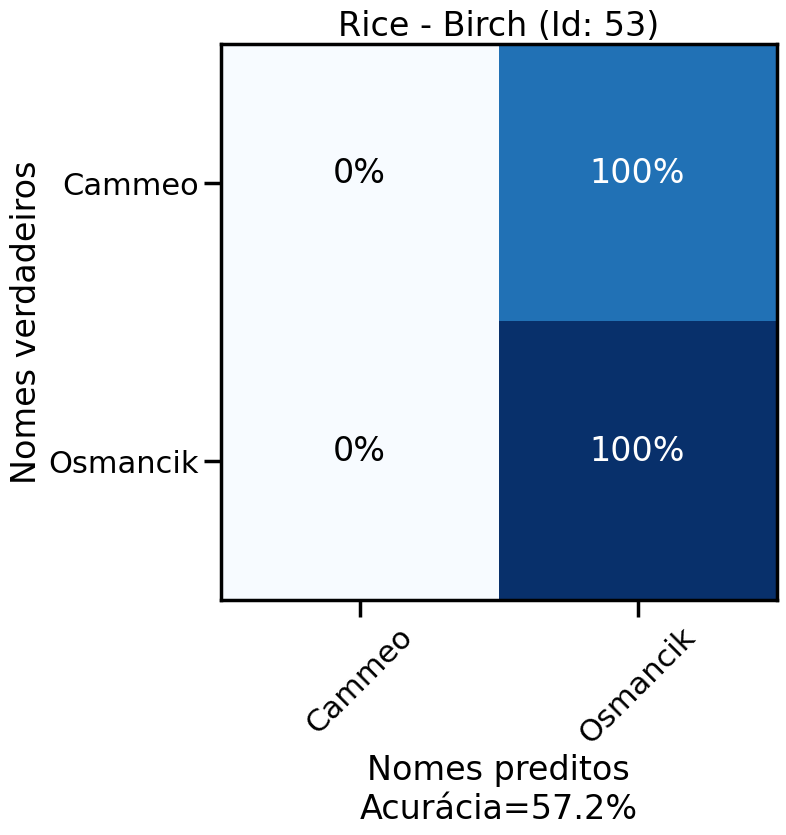

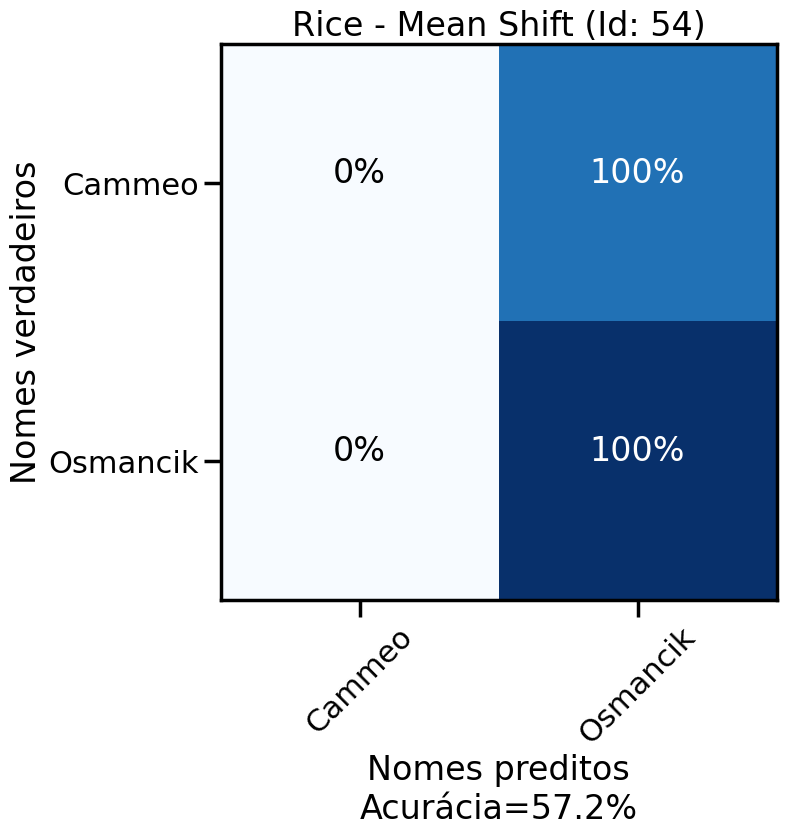

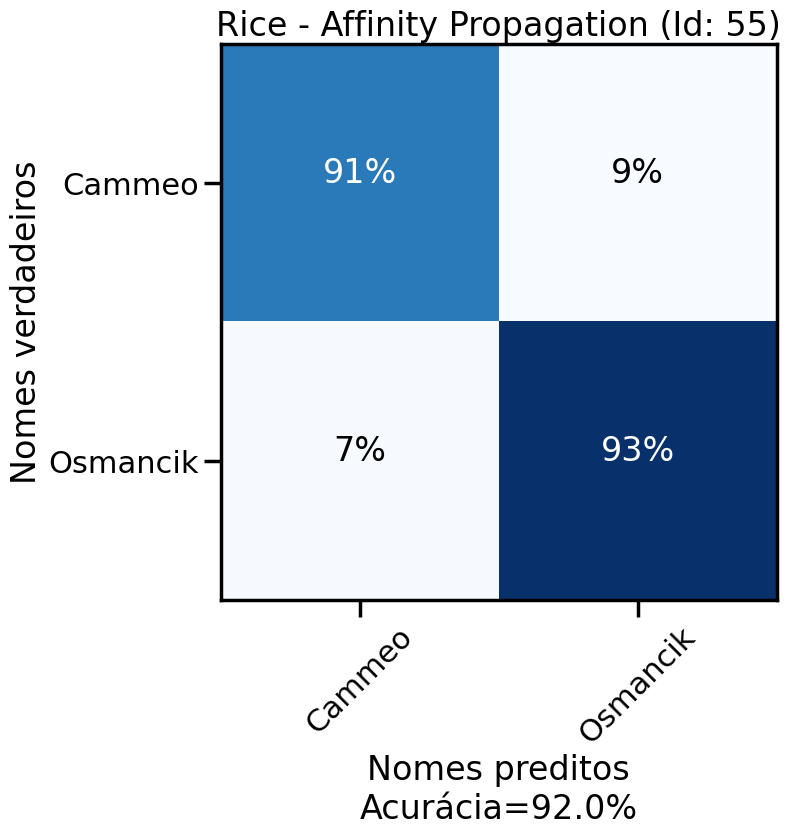

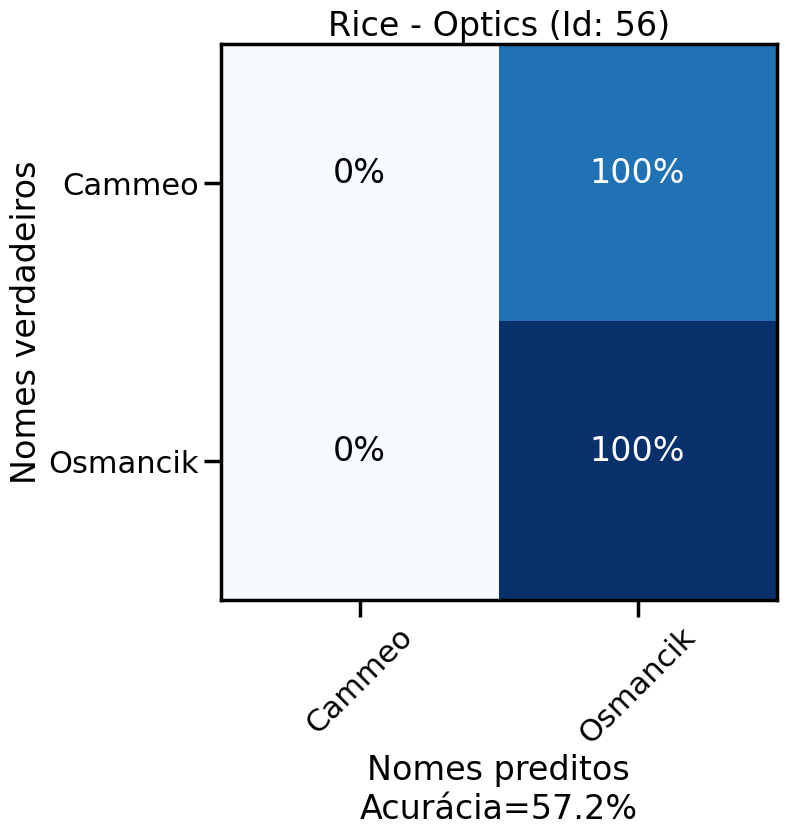

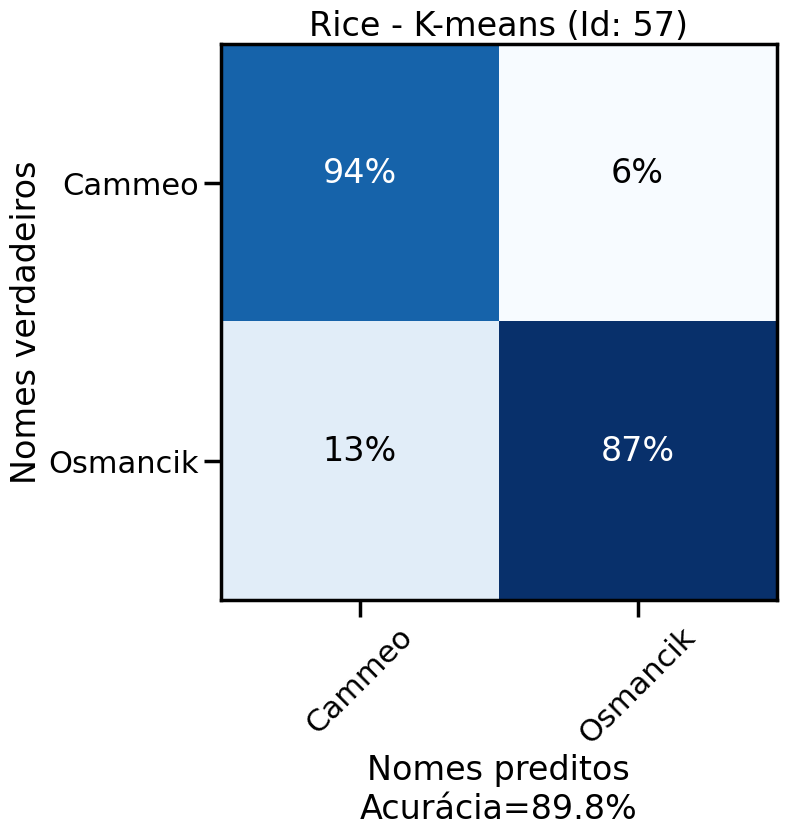

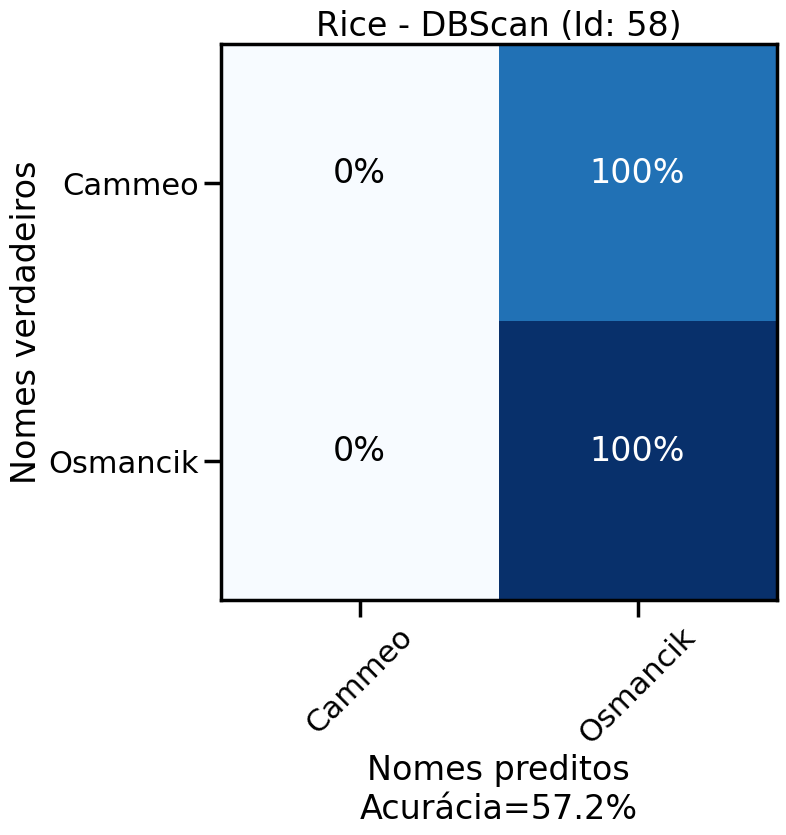

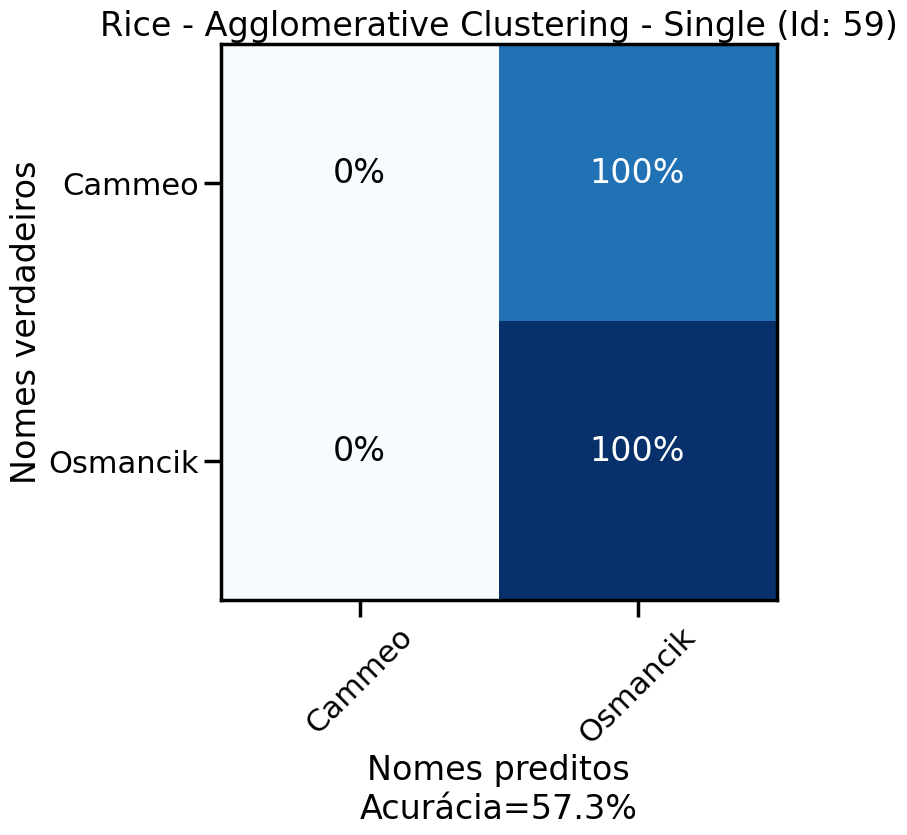

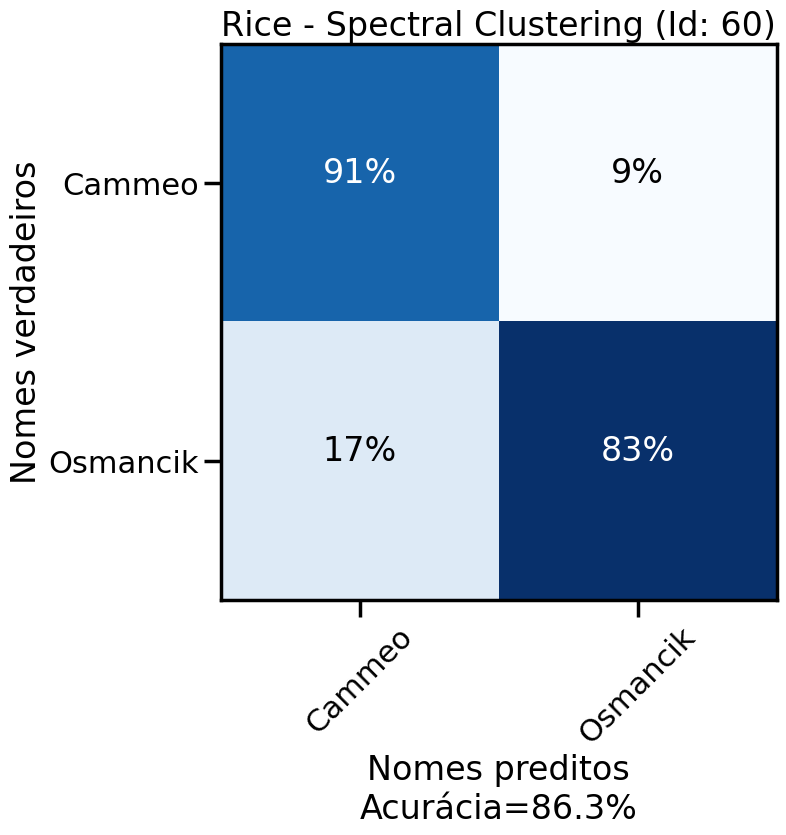

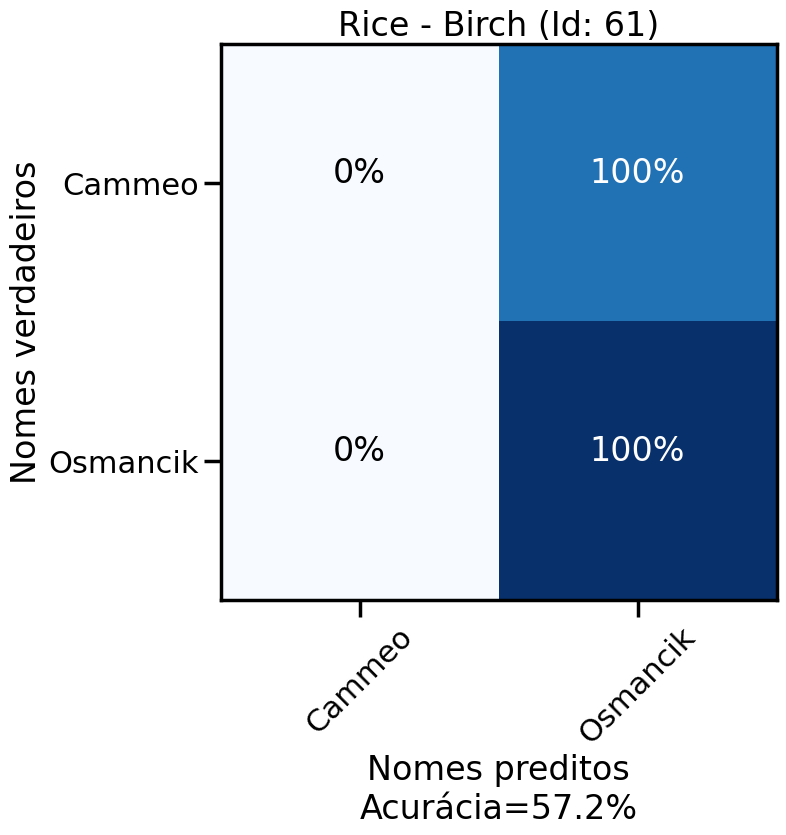

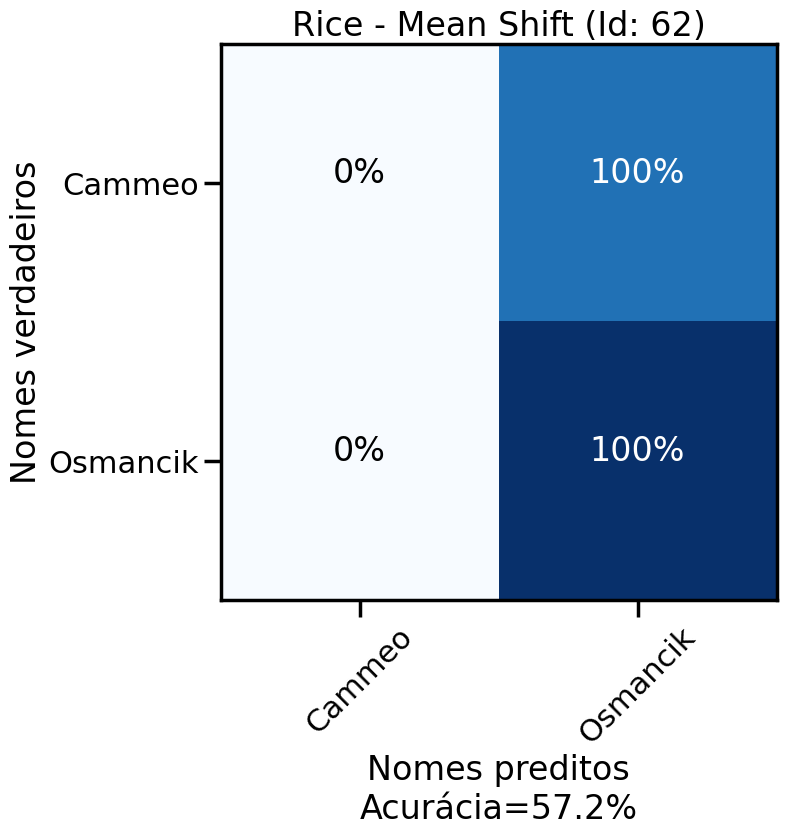

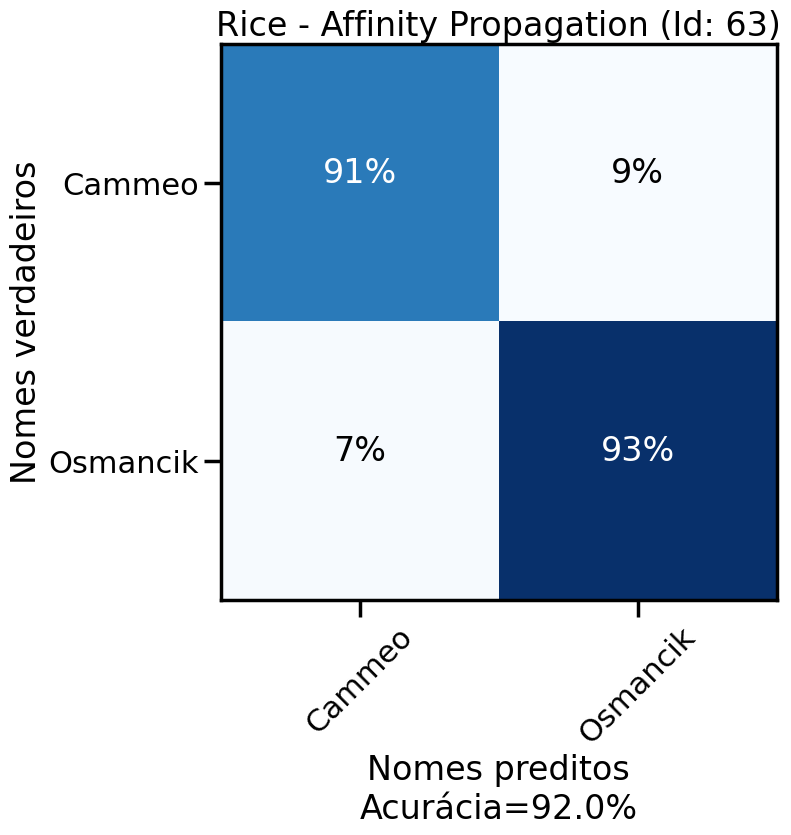

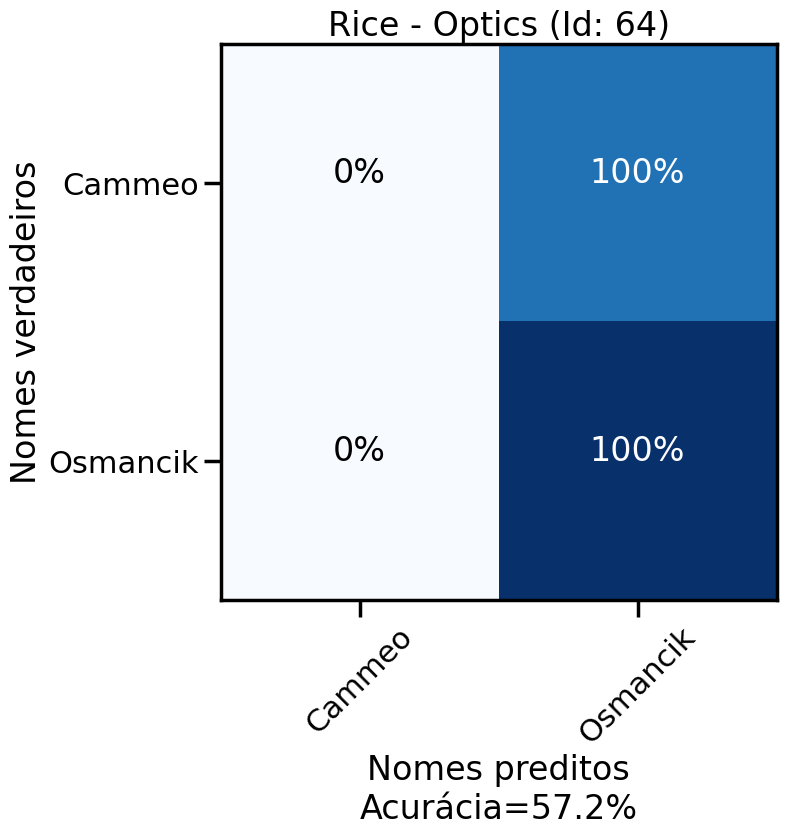

In [86]:
dataList = {
        'Iris': "iris.csv",
        'Rice': "Rice_Cammeo_Osmancik.csv"
        }

parametros = [{
        'RandomSeed': 10,
        'Nr. Cluster': 1,
        'Eps': 0.1,
        'Linkage': "Ward",
        'Threshold':0.1,
        'Max. Iter':100,
        'Min Samples': 0.1
        },
        {
        'RandomSeed': 57,
        'Nr. Cluster': 1.5,
        'Eps': 0.5,
        'Linkage': "Complete",
        'Threshold':0.5,
        'Max. Iter':150,
        'Min Samples': 0.3
        },
        {
        'RandomSeed': 965,
        'Nr. Cluster': 2,
        'Eps': 1.0,
        'Linkage': "Average",
        'Threshold':1.0,
        'Max. Iter':300,
        'Min Samples': 0.5
        },
        {
        'RandomSeed': 7821,
        'Nr. Cluster': 3,
        'Eps': 1.5,
        'Linkage': "Single",
        'Threshold':1.5,
        'Max. Iter':500,
        'Min Samples': 0.8
        }]

executionId = 1;

with open(result_dados, 'w') as csv_file:
    writer = csv.writer(csv_file, lineterminator="\n")

    for dataKey in dataList:
        print(color.BOLD + color.UNDERLINE + dataKey + " Dataset" + color.END + "\n")
        
        data = load_file(dataList[dataKey], "class")

        for param in parametros:
             clusterLength = int( len(data["LabelsEncoded"]) * param["Nr. Cluster"] )

             #'''
             localParam = param.copy()
             localParam["ID"]=executionId;
             k_means = sklearn.cluster.KMeans(clusterLength, n_init='auto', random_state=param["RandomSeed"], max_iter=param["Max. Iter"])
             clusterResult = benchmark_algorithm(executionId, dataKey, data, "K-means", k_means.fit, (), {});
             localParam.update({'Dataset': dataKey, 'Cluster': "K-means", 'Eps': None, 'Linkage': None, 'Threshold': None, 'Min Samples': None});
             localParam.update({'Time Taken (seg)': clusterResult['TimeTaken'], 'Accuracy Score': clusterResult['AccuracyScore'], 'Purity Score': clusterResult['PurityScore'], 'Adjusted Rand Index': clusterResult['AdjustedRandScore'], 'Jaccard Score': clusterResult['JaccardScore']});

             if(executionId==1):
                  writer.writerow(localParam.keys())
             writer.writerow(localParam.values())

             executionId+=1;
             #'''

             #'''
             localParam = param.copy()
             localParam["ID"]=executionId;
             dbscan = sklearn.cluster.DBSCAN(eps=param["Eps"])
             clusterResult = benchmark_algorithm(executionId, dataKey, data, "DBScan", dbscan.fit, (), {})
             localParam.update({'Dataset': dataKey, 'Cluster': "DBScan", 'RandomSeed': None, 'Linkage': None, 'Threshold': None, 'Max. Iter': None, 'Min Samples': None});
             localParam.update({'Time Taken (seg)': clusterResult['TimeTaken'], 'Accuracy Score': clusterResult['AccuracyScore'], 'Purity Score': clusterResult['PurityScore'], 'Adjusted Rand Index': clusterResult['AdjustedRandScore'], 'Jaccard Score': clusterResult['JaccardScore']});
             writer.writerow(localParam.values())
             executionId+=1;
             #'''

             #'''
             localParam = param.copy()
             localParam["ID"]=executionId;
             agglomerative = sklearn.cluster.AgglomerativeClustering(clusterLength, linkage=param["Linkage"].lower())
             clusterResult = benchmark_algorithm(executionId, dataKey, data, "Agglomerative Clustering - "+param["Linkage"], agglomerative.fit, (), {})
             localParam.update({'Dataset': dataKey, 'Cluster': "Agglomerative Clustering - "+param["Linkage"], 'RandomSeed': None, 'Eps': None, 'Threshold': None, 'Max. Iter': None, 'Min Samples': None});
             localParam.update({'Time Taken (seg)': clusterResult['TimeTaken'], 'Accuracy Score': clusterResult['AccuracyScore'], 'Purity Score': clusterResult['PurityScore'], 'Adjusted Rand Index': clusterResult['AdjustedRandScore'], 'Jaccard Score': clusterResult['JaccardScore']});
             writer.writerow(localParam.values())
             executionId+=1;
             #'''

             #'''
             localParam = param.copy()
             localParam["ID"]=executionId;
             spectral = sklearn.cluster.SpectralClustering(clusterLength, random_state=param["RandomSeed"], n_jobs=1)
             clusterResult = benchmark_algorithm(executionId, dataKey, data, "Spectral Clustering", spectral.fit, (), {})
             localParam.update({'Dataset': dataKey, 'Cluster': "Spectral Clustering", 'Eps': None, 'Linkage': None, 'Threshold': None, 'Max. Iter': None, 'Min Samples': None});
             localParam.update({'Time Taken (seg)': clusterResult['TimeTaken'], 'Accuracy Score': clusterResult['AccuracyScore'], 'Purity Score': clusterResult['PurityScore'], 'Adjusted Rand Index': clusterResult['AdjustedRandScore'], 'Jaccard Score': clusterResult['JaccardScore']});
             writer.writerow(localParam.values())
             executionId+=1;
             #'''

             #'''
             localParam = param.copy()
             localParam["ID"]=executionId;
             birch = sklearn.cluster.Birch(n_clusters=clusterLength, threshold=param["Threshold"])
             clusterResult = benchmark_algorithm(executionId, dataKey, data, "Birch", birch.fit, (), {})
             localParam.update({'Dataset': dataKey, 'Cluster': "Birch", 'RandomSeed': None, 'Eps': None, 'Linkage': None, 'Max. Iter': None, 'Min Samples': None});
             localParam.update({'Time Taken (seg)': clusterResult['TimeTaken'], 'Accuracy Score': clusterResult['AccuracyScore'], 'Purity Score': clusterResult['PurityScore'], 'Adjusted Rand Index': clusterResult['AdjustedRandScore'], 'Jaccard Score': clusterResult['JaccardScore']});
             writer.writerow(localParam.values())
             executionId+=1;
             #'''

             #'''
             localParam = param.copy()
             localParam["ID"]=executionId;
             meanShift = sklearn.cluster.MeanShift(n_jobs=1, max_iter=param["Max. Iter"])
             clusterResult = benchmark_algorithm(executionId, dataKey, data, "Mean Shift", meanShift.fit, (), {})
             localParam.update({'Dataset': dataKey, 'Cluster': "Mean Shift", 'RandomSeed': None, 'Nr. Cluster': None, 'Eps': None, 'Linkage': None, 'Threshold': None, 'Min Samples': None});
             localParam.update({'Time Taken (seg)': clusterResult['TimeTaken'], 'Accuracy Score': clusterResult['AccuracyScore'], 'Purity Score': clusterResult['PurityScore'], 'Adjusted Rand Index': clusterResult['AdjustedRandScore'], 'Jaccard Score': clusterResult['JaccardScore']});
             writer.writerow(localParam.values())
             executionId+=1;
             #'''

             #'''
             localParam = param.copy()
             localParam["ID"]=executionId;
             affinity_prop = sklearn.cluster.AffinityPropagation(random_state=param["RandomSeed"], max_iter=param["Max. Iter"])
             clusterResult = benchmark_algorithm(executionId, dataKey, data, "Affinity Propagation", affinity_prop.fit, (), {})
             localParam.update({'Dataset': dataKey, 'Cluster': "Affinity Propagation", 'Nr. Cluster': None, 'Eps': None, 'Linkage': None, 'Threshold': None, 'Min Samples': None});
             localParam.update({'Time Taken (seg)': clusterResult['TimeTaken'], 'Accuracy Score': clusterResult['AccuracyScore'], 'Purity Score': clusterResult['PurityScore'], 'Adjusted Rand Index': clusterResult['AdjustedRandScore'], 'Jaccard Score': clusterResult['JaccardScore']});
             writer.writerow(localParam.values())
             executionId+=1;
             #'''

             #'''
             localParam = param.copy()
             localParam["ID"]=executionId;
             optics= sklearn.cluster.OPTICS(min_samples = param["Min Samples"], eps = param["Eps"], n_jobs=1)
             clusterResult = benchmark_algorithm(executionId, dataKey, data, "Optics", optics.fit, (), {})
             localParam.update({'Dataset': dataKey, 'Cluster': "Optics", 'RandomSeed': None, 'Nr. Cluster': None, 'Linkage': None, 'Threshold': None, 'Max. Iter': None});
             localParam.update({'Time Taken (seg)': clusterResult['TimeTaken'], 'Accuracy Score': clusterResult['AccuracyScore'], 'Purity Score': clusterResult['PurityScore'], 'Adjusted Rand Index': clusterResult['AdjustedRandScore'], 'Jaccard Score': clusterResult['JaccardScore']});
             writer.writerow(localParam.values())
             executionId+=1;
             #'''